# Install Relevant Libraries

In [0]:
#!pip install re
#!pip install numpy
#!pip install pandas
#!pip install scikit-learn
#!pip install matplotlib
#!pip install seaborn
!pip install xgboost
!pip install wordcloud

# Import Relevant Libraries

In [0]:
import re
import html
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import warnings
warnings.simplefilter("ignore")

from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud

# Read Data

In [0]:
sentiment_df = pd.read_csv("Sentiment.csv")
elections_df = pd.read_csv("Canadian_elections_2019.csv")

# Data Overview

Taking a look at the data:

In [0]:
sentiment_df.head()

,sentiment,text
0,Positive,RT @Diplomtc_Immnty: @realDonaldTrump They tri...
1,Negative,"@chiefy74 Damn i'm jealous, i wanna watch the ..."
2,Positive,I'm listening The Beatles now. They're great
3,Positive,@ddlovato could i please get a shout out or an...
4,Positive,@salspizza just spotted ur message there Tony ...


In [0]:
sentiment_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133811 entries, 0 to 133810
Data columns (total 2 columns):
sentiment    133811 non-null object
text         133797 non-null object
dtypes: object(2)
memory usage: 2.0+ MB


In [0]:
elections_df.head()

,sentiment,negative_reason,text
0,Negative,Women Reproductive right and Racism,"b""@RosieBarton So instead of your suggestion, ..."
1,Positive,NaN,"b""#AllWomanSpacewalk it's real!\n@Space_Statio..."
2,Negative,Economy,"b""#Brantford It's going to cost YOU $94 BILLIO..."
3,Positive,NaN,"b""#Canada #CanadaElection2019 #CanadaVotes \n#..."
4,Negative,Economy,"b""#Canada #taxpayers are sick &amp; tired of h..."


In [0]:
elections_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2133 entries, 0 to 2132
Data columns (total 3 columns):
sentiment          2133 non-null object
negative_reason    1007 non-null object
text               2133 non-null object
dtypes: object(3)
memory usage: 50.1+ KB


# Data Cleaning

## Missing Data

First, the datasets are checked for any missing data using a heatmap.

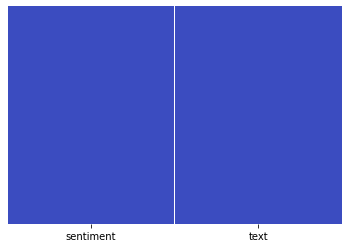

In [0]:
fig, ax = plt.subplots()
sns.heatmap(sentiment_df.isnull(), cmap='coolwarm', yticklabels=False, cbar=False)

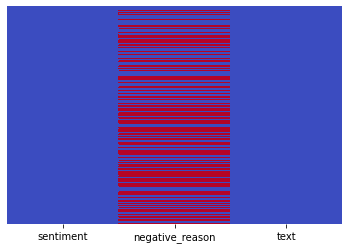

In [0]:
fig, ax = plt.subplots()
sns.heatmap(elections_df.isnull(), cmap='coolwarm', yticklabels=False, cbar=False)

From the heatmaps, we see that there are no missing data in the sentiment dataframe. However, there are missing data in the 'negative_reason' column in the elections dataframe, which is due to no negative reasons given for tweets with a positive sentiment.

## Removing Noise

The data sets as given contain too much 'noise'. Therefore, they need to be cleaned first in preparation for analysis. The following requirements must be met after data cleaning:


*   All html tags and attributes (eg. /<[^>]+>/) are removed
*   All html character codes (eg. &...;) are replaced with an ASCII equivalent

*   All URLs are removed
*   All characters in 'text' are in lowercase

*   All stop words are removed
*   A tweet that is empty after pre-processing is preserved as such







In [0]:
stop_words = pd.read_fwf("stop_words.txt", header=None) # Read stop_words as a dataframe
stop_words = stop_words[0].to_list() # Convert stop_words to list

In [0]:
def DataClean(df, stop_words):

  df['cleaned_text'] = df['text'].astype(str)

  # Remove these characters (specifically for elections dataframe)
  df['cleaned_text'] = df['cleaned_text'].str.replace('b"', '')
  df['cleaned_text'] = df['cleaned_text'].str.replace('\n', '')

  # Remove tags and attributes
  df['cleaned_text'] = df['cleaned_text'].str.replace('/<[^>]+>/', '')

  # Replace html character codes with ASCII equivalent
  df['cleaned_text'] = html.unescape(df['cleaned_text'])

  # Remove URLs
  df['cleaned_text'] = df['cleaned_text'].str.replace('http\S+', '')

  # Change all uppercase letters to lowercase letters
  df['cleaned_text'] = df['cleaned_text'].str.lower()

  # Remove punctuation and tokenize
  df['cleaned_text'] = df['cleaned_text'].str.replace('[^\w\s]', '')
  df['cleaned_text'] = df['cleaned_text'].str.split() # Tokenize

  # Remove stop words
  df['cleaned_text'] = df['cleaned_text'].apply(lambda x: [word for word in x if word not in stop_words])
 
  # Get word count
  df['word_count'] = df['cleaned_text'].str.len()

  return df

In [0]:
# Apply DataClean function to sentiment dataframe
sentiment_df = DataClean(sentiment_df, stop_words)

In [0]:
# Verify
sentiment_df.head()

,sentiment,text,cleaned_text,word_count
0,Positive,RT @Diplomtc_Immnty: @realDonaldTrump They tri...,"[rt, diplomtc_immnty, realdonaldtrump, amp, po...",11
1,Negative,"@chiefy74 Damn i'm jealous, i wanna watch the ...","[chiefy74, damn, jealous, wanna, watch, fight,...",8
2,Positive,I'm listening The Beatles now. They're great,"[listening, beatles, great]",3
3,Positive,@ddlovato could i please get a shout out or an...,"[ddlovato, shout, huge, fan, cant, wait, cd]",7
4,Positive,@salspizza just spotted ur message there Tony ...,"[salspizza, spotted, ur, message, tony, replied]",6


In [0]:
# Apply DataClean function to elections dataframe
elections_df = DataClean(elections_df, stop_words)

In [0]:
# Verify
elections_df.head()

,sentiment,negative_reason,text,cleaned_text,word_count
0,Negative,Women Reproductive right and Racism,"b""@RosieBarton So instead of your suggestion, ...","[rosiebarton, suggestion, agree, canadian, wom...",18
1,Positive,NaN,"b""#AllWomanSpacewalk it's real!\n@Space_Statio...","[allwomanspacewalk, realnspace_station, netobi...",7
2,Negative,Economy,"b""#Brantford It's going to cost YOU $94 BILLIO...","[brantford, going, cost, 94, billion, 4, years...",11
3,Positive,NaN,"b""#Canada #CanadaElection2019 #CanadaVotes \n#...","[canada, canadaelection2019, canadavotes, nelx...",7
4,Negative,Economy,"b""#Canada #taxpayers are sick &amp; tired of h...","[canada, taxpayers, sick, amp, tired, hard, ea...",23


# Exploratory Analysis

## Political Affiliation

The following function assigns a political party to each of the tweets in the elections dataframe. Words associated with each political party are recorded in lists. Each tweet is then searched for these associated words. The party whose associated words appeared the most is then assigned to the tweet.

In [0]:
def AssignParty(text):

  # Create list of words associated with each political party
  lib_words = ['justin','trudeau','justintrudeau', 'pmtrudeau', 'libéral', 'pm', 'primeminister', 'liberal', 'liberals', 
               'realchange', 'libs','lib', 'liberal_party', 'lpc','ptlib', 'teamtrudeau', 'red']

  cons_words = ['andrewscheer', 'andrew', 'scheer', 'conservative', 'cpc', 'conservatives', 'pcers', 'pc', 'pctory', 'tory', 
                'tories', 'harper', 'blue']

  ndp_words = ['jagmeetsingh','jagmeet','singh', 'ndp', 'ndp_hq', 'ptndp', 'orange', 'ndp2019', 'tommulcair', 'mulcair', 
               'ready4change']

  party = []

  # Search through the tweet for all of the words associated with the parties      
  for word in lib_words:   
    if word in text:
      party.append('Liberal')
        
  for word in cons_words:
    if word in text:
      party.append('Conservative')
           
  for word in ndp_words:
    if word in text:
      party.append('NDP')

  # Choose the most common party name for this tweet
  if len(party) > 1:
    more_frequent = max(set(party), key=party.count)
    party = []
    party.append(more_frequent)
  elif len(party) == 0:
    party.append('Other')
        
  return party

In [0]:
party_list = [] # Declare empty party list

for i in range(elections_df.shape[0]): # For each tweet in elections dataframe  
  party = AssignParty(elections_df.cleaned_text[i])[0] # Determine party using AssignParty function
  party_list.append(party) # Append party to list

elections_df['party'] = party_list # Add 'party' column in elections dataframe

In [0]:
elections_df['party'].value_counts()

Other           1211
Conservative     423
Liberal          405
NDP               94
Name: party, dtype: int64

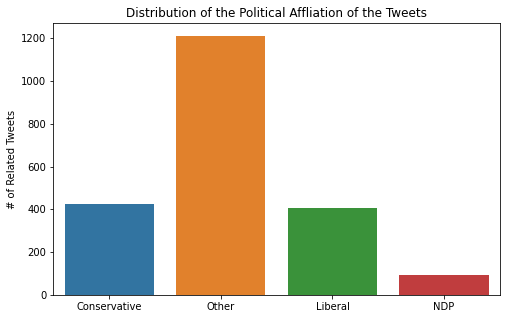

In [0]:
# Plot distribution of political affliations of tweets
party_count = Counter(party_list)
x = list(party_count.keys()) # Get name of parties as a list
y = list(party_count.values()) # Get values of each party as a list

fig = plt.subplots(figsize=(8,5))
sns.barplot(x, y)
plt.ylabel('# of Related Tweets')
plt.title('Distribution of the Political Affliation of the Tweets')
plt.show()

From the plot above, the defined function was able to assign a political party to almost half of the tweets. The Conservative Party and the Liberal Party have similiar numbers of related tweets, while the New Democratic Party have significantly less related tweets. It is very likely that there are still many tweets in the 'Other' category which are associated to one of the three political parties. More associated words can be added to the respective list of each political party to better group the tweets and improve the quality of the data.  

## Visualization - Word Cloud

Word Cloud is a data visualization technique used to indicate the frequency or importance of words in text data through its size. The following plots have been commented out to avoid overly long runtimes. Please see the plots in the presentation slides. 

### Generic Tweets

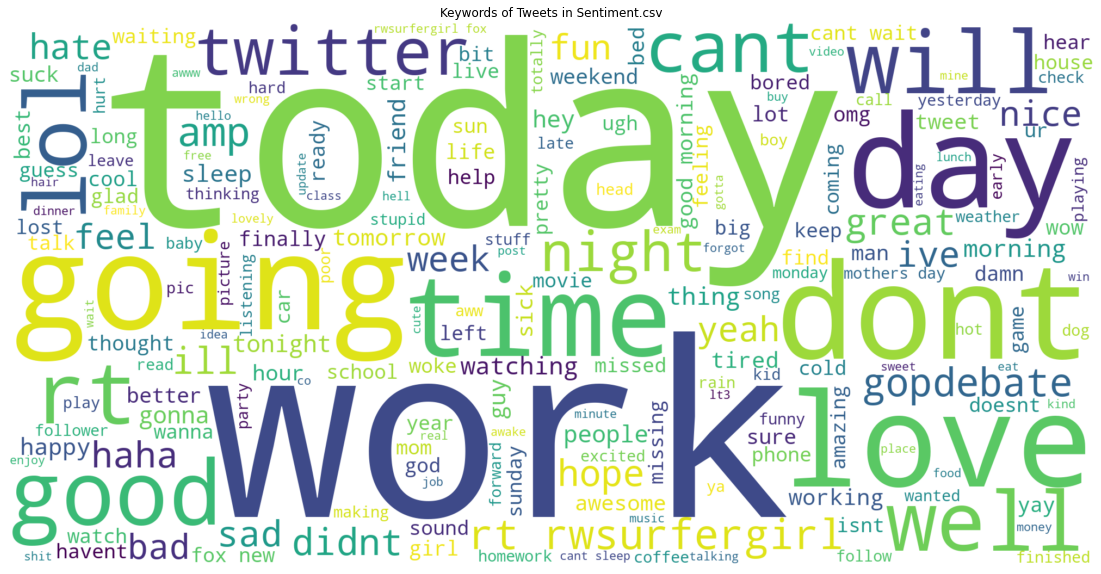

In [0]:
"""
# Word cloud plot of tweets in sentiment dataframe
tweet_words = sentiment_df['cleaned_text'].to_string() # Tokenized words to string
wordcloud = WordCloud(width=2000, height=1000, background_color='white').generate(tweet_words)

plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Keywords of Tweets in Sentiment.csv')
plt.axis("off")
plt.show()
"""

### Election Tweets

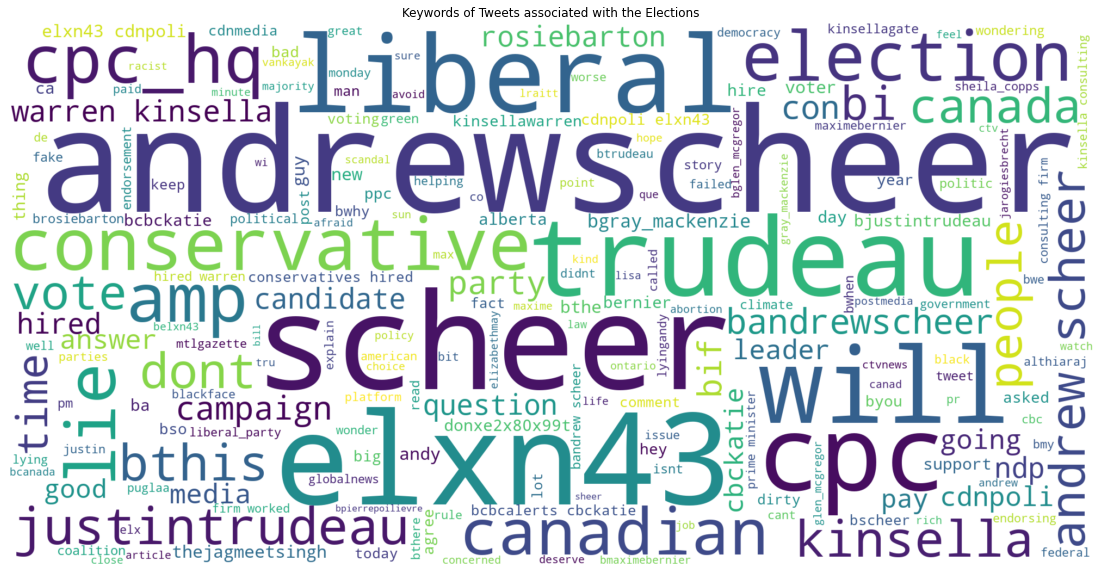

In [0]:
"""
# Word cloud plot of tweets in elections dataframe
tweet_words = elections_df['cleaned_text'].to_string() # Tokenized words to string
wordcloud = WordCloud(width=2000, height=1000, background_color='white').generate(tweet_words)

plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Keywords of Tweets associated with the Elections')
plt.axis("off")
plt.show()
"""

#### Liberal Party

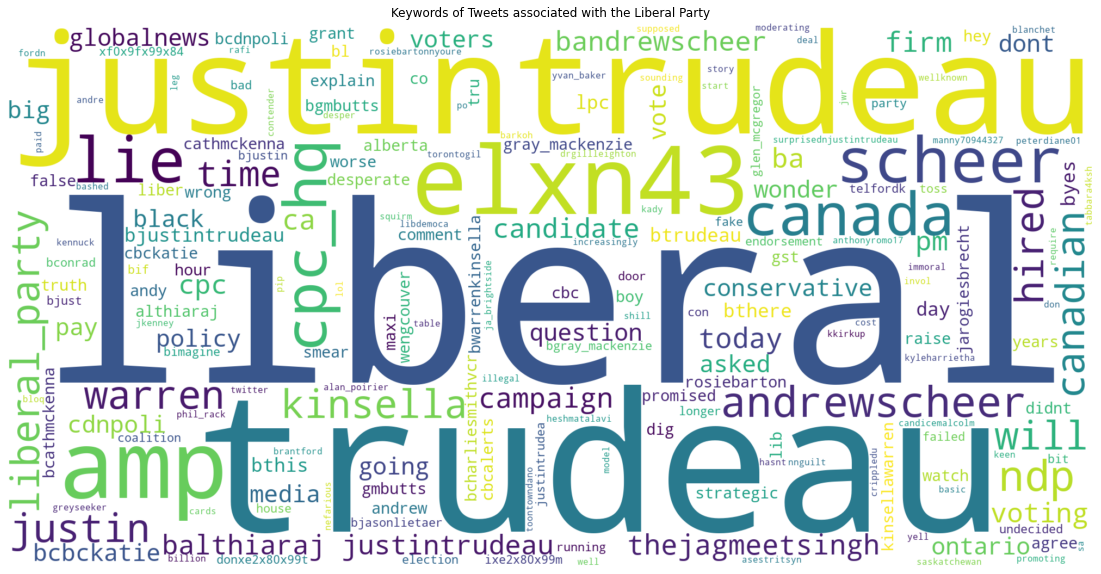

In [0]:
"""
# Tokenized words in election tweets associated with the Liberal Party
lib_tweet_words = elections_df.loc[elections_df['party'] == 'Liberal', 'cleaned_text'].to_string()

# Word cloud plot
wordcloud = WordCloud(width=2000, height=1000, background_color='white').generate(lib_tweet_words)

plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Keywords of Tweets associated with the Liberal Party')
plt.axis("off")
plt.show()
"""

#### Conservative Party

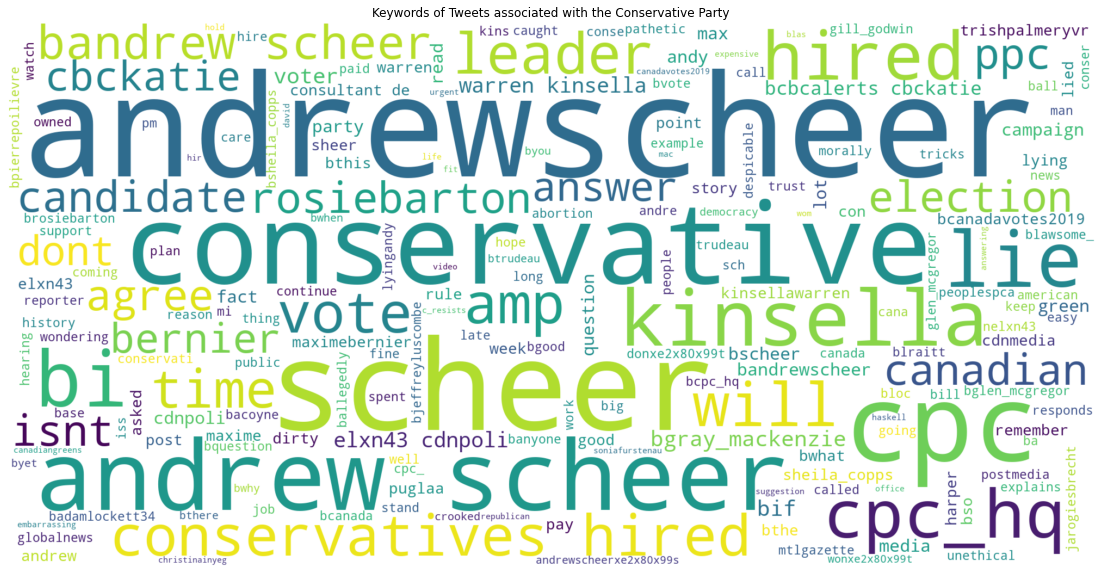

In [0]:
"""
# Tokenized words in election tweets associated with the Conservative Party
cons_tweet_words = elections_df.loc[elections_df['party'] == 'Conservative', 'cleaned_text'].to_string()

# Word cloud plot
wordcloud = WordCloud(width=2000, height=1000, background_color='white').generate(cons_tweet_words)

plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Keywords of Tweets associated with the Conservative Party')
plt.axis("off")
plt.show()
"""

#### New Democratic Party

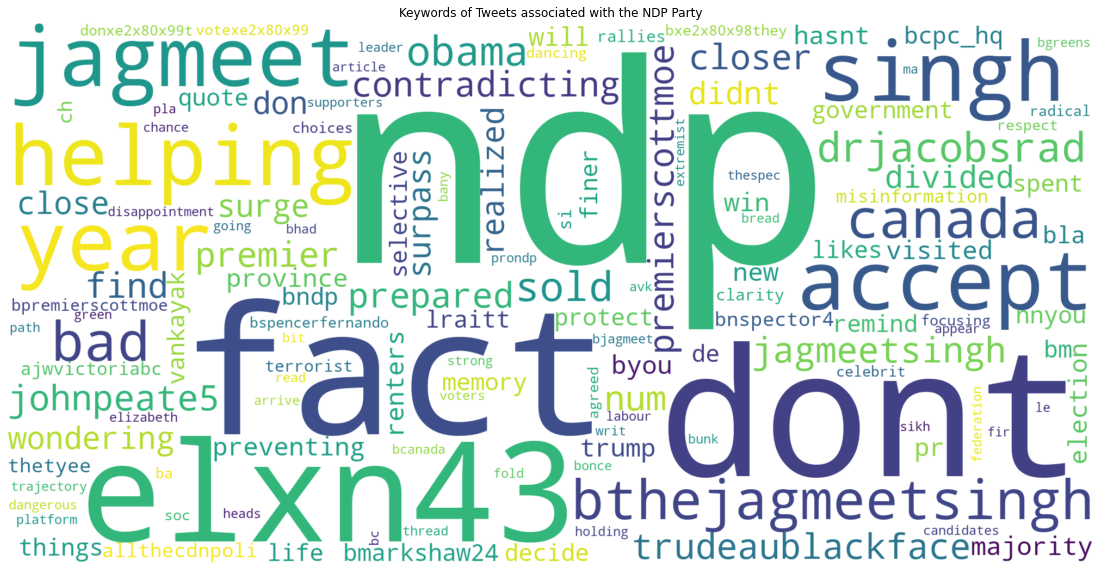

In [0]:
"""
# Tokenized words in election tweets associated with the NDP
ndp_tweet_words = elections_df.loc[elections_df['party'] == 'NDP', 'cleaned_text'].to_string()

# Word cloud plot
wordcloud = WordCloud(width=2000, height=1000, background_color='white').generate(ndp_tweet_words)

plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Keywords of Tweets associated with the NDP Party')
plt.axis("off")
plt.show()
"""

#### Other

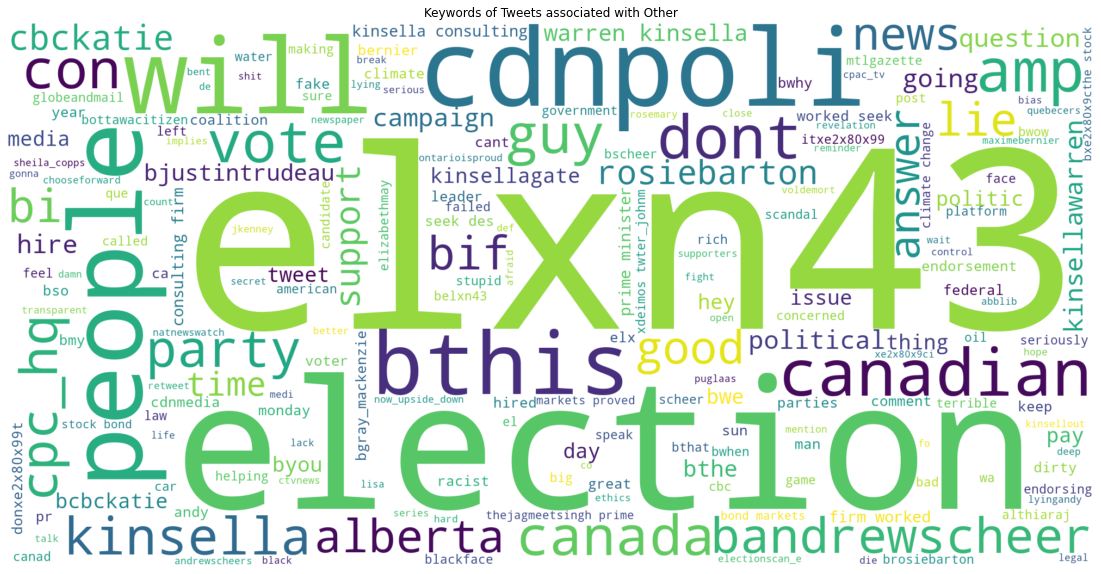

In [0]:
"""
# Tokenized words in election tweets associated with other
other_tweet_words = elections_df.loc[elections_df['party'] == 'Other', 'cleaned_text'].to_string()

# Word cloud plot
wordcloud = WordCloud(width=2000, height=1000, background_color='white').generate(other_tweet_words)

plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Keywords of Tweets associated with Other')
plt.axis("off")
plt.show()
"""

# Model Preparation

Looking at the 'sentiment' target, we notice that there are three classes.

In [0]:
sentiment_df['sentiment'].value_counts()

Negative    71428
Positive    59241
Neutral      3142
Name: sentiment, dtype: int64

The 'Neutral' class only accounts for less than 2.5% of the total tweets so they are dropped.

In [0]:
# Drop all data points where sentiment is neutral
sentiment_df = sentiment_df[sentiment_df['sentiment'] != 'Neutral']

In [0]:
# Verify
sentiment_df['sentiment'].value_counts()

Negative    71428
Positive    59241
Name: sentiment, dtype: int64

Many machine learning models can only handle numerical data, so categorical data are converted to numerical data. The 'sentiment' target is of categorical data, so it is converted to numerical data in preparation for modelling.

In [0]:
# Encode sentiment classes as new column
sentiment_df['encoded_sentiment'] = sentiment_df['sentiment'].map({
    'Positive': 1, 
    'Negative': 0})

In [0]:
# Verify
sentiment_df['encoded_sentiment'].value_counts()

0    71428
1    59241
Name: encoded_sentiment, dtype: int64

## Feature Creation

In [0]:
# Join tokenized words in each tweet to one string
sentiment_df['join_text'] = sentiment_df['cleaned_text'].str.join(" ")

In [0]:
# Split sentiment dataframe into training and testing data
X_train, X_test, y_train, y_test = train_test_split(sentiment_df['join_text'], sentiment_df['encoded_sentiment'], test_size=0.3, random_state=0)

### Word Frequency (WF)

WF records the number of times a word occurs in a document. The number of features selected is 49 to avoid overly long runtimes when applied to models.

In [0]:
WF_vect = CountVectorizer(min_df=0.01) # Call CountVectorizer and ignore terms that have a document frequency lower than 0.01
WF_train = WF_vect.fit_transform(X_train).toarray() # Fit vectorizer using training data and transform training data
WF_test = WF_vect.transform(X_test).toarray() # Transform testing data using fitted vectorizer

WFtrain_df = pd.DataFrame(WF_train, columns=WF_vect.get_feature_names()) # Obtain training data results in dataframe
WFtest_df = pd.DataFrame(WF_test, columns=WF_vect.get_feature_names()) # Obtain testing data results in dataframe

In [0]:
WFtrain_df.head()

,amp,bad,bed,better,cant,day,days,didnt,dont,feel,fun,going,gonna,good,gopdebate,gopdebates,great,haha,happy,hate,hey,hope,ill,ive,lol,long,love,morning,nice,night,people,rt,rwsurfergirl,sad,school,sleep,time,today,tomorrow,tonight,twitter,wait,watching,week,well,will,work,yeah,ðÿºðÿ
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
WFtrain_df.shape

(91468, 49)

In [0]:
WFtest_df.head()

,amp,bad,bed,better,cant,day,days,didnt,dont,feel,fun,going,gonna,good,gopdebate,gopdebates,great,haha,happy,hate,hey,hope,ill,ive,lol,long,love,morning,nice,night,people,rt,rwsurfergirl,sad,school,sleep,time,today,tomorrow,tonight,twitter,wait,watching,week,well,will,work,yeah,ðÿºðÿ
0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
WFtest_df.shape

(39201, 49)

### Term Frequency–Inverse Document Frequency (TF-IDF)

TF-IDF reflects how important a word is to a document.

In [0]:
TFIDF_vect = TfidfVectorizer(max_features=49) # Call TfidfVectorizer and choose an equivalent number of features as WF
TFIDF_train = TFIDF_vect.fit_transform(X_train).toarray() # Fit vectorizer using training data and transform training data
TFIDF_test = TFIDF_vect.transform(X_test).toarray() # Transform testing data using fitted vectorizer

TFIDFtrain_df = pd.DataFrame(TFIDF_train, columns=TFIDF_vect.get_feature_names()) # Obtain training data results in dataframe
TFIDFtest_df = pd.DataFrame(TFIDF_test, columns=TFIDF_vect.get_feature_names()) # Obtain testing data results in dataframe

In [0]:
TFIDFtrain_df.head()

,amp,bad,bed,better,cant,day,days,didnt,dont,feel,fun,going,gonna,good,gopdebate,gopdebates,great,haha,happy,hate,hey,hope,ill,ive,lol,love,morning,nice,night,people,rt,rwsurfergirl,sad,school,sleep,time,today,tomorrow,tonight,trump,twitter,wait,watching,week,well,will,work,yeah,ðÿºðÿ
0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
1,0.0,0.0,0.634643,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.578257,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.512687,0.0,0.0
2,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
3,0.0,0.0,0.000000,0.0,0.799646,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.414524,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.434437,0.0,0.000000,0.0,0.0
4,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0


In [0]:
TFIDFtrain_df.shape

(91468, 49)

In [0]:
TFIDFtest_df.head()

,amp,bad,bed,better,cant,day,days,didnt,dont,feel,fun,going,gonna,good,gopdebate,gopdebates,great,haha,happy,hate,hey,hope,ill,ive,lol,love,morning,nice,night,people,rt,rwsurfergirl,sad,school,sleep,time,today,tomorrow,tonight,trump,twitter,wait,watching,week,well,will,work,yeah,ðÿºðÿ
0,0.42518,0.0,0.0,0.0,0.0,0.0,0.510586,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.413095,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.45317,0.0,0.0,0.0,0.0,0.0,0.0,0.427216,0.0,0.0,0.0,0.000000
1,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
2,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.341907,0.385941,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.442509,0.347483,0.453475,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.460381
3,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
4,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000


In [0]:
TFIDFtest_df.shape

(39201, 49)

# Model Implementation

## Model Training

The following algorithms with their default parameters are used with cross-validation on the sentiment.csv training data with each feature:

*   Logistic Regression
*   k-Nearest Neighbor (k-NN)

*   Naive Bayes
*   Support Vector Machine (SVM)

*   Decision Trees
*   Random Forest

*   XGBoost

In [0]:
# 10-fold cross-validation of selected model
def K_Fold1(X, y, model):
  kF = KFold(n_splits=10)
  #scaler = StandardScaler()

  accuracy = np.zeros(10)
  np_idx = 0

  for train_idx, test_idx in kF.split(X): # Define train and validation sets
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    #X_train = scaler.fit_transform(X_train) # Fitting and standardizing training data
    #X_test = scaler.transform(X_test) # Standardizing testing data

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    TN = confusion_matrix(y_test, y_pred)[0][0]
    FP = confusion_matrix(y_test, y_pred)[0][1]
    FN = confusion_matrix(y_test, y_pred)[1][0]
    TP = confusion_matrix(y_test, y_pred)[1][1]
    total = TN + FP + FN + TP
    ACC = (TP + TN) / float(total)

    accuracy[np_idx] = ACC * 100

    np_idx += 1
    print("Fold {}: Accuracy = {}%" .format(np_idx, round((accuracy[np_idx-1]), 3))) # Print fold accuracy

  return accuracy

### Feature: WF

#### Logistic Regression

In [0]:
# Logistic Regression
print("Logistic Regression:")
model = LogisticRegression()
accuracy1 = K_Fold1(WFtrain_df, y_train, model) # Call defined function
print("Cross-validation score of {}% with a variance of {}%" .format(round(np.mean(accuracy1), 3), round(np.var(accuracy1), 3)))

Logistic Regression:
Fold 1: Accuracy = 62.042%
Fold 2: Accuracy = 62.25%
Fold 3: Accuracy = 60.883%
Fold 4: Accuracy = 61.113%
Fold 5: Accuracy = 62.392%
Fold 6: Accuracy = 61.681%
Fold 7: Accuracy = 61.736%
Fold 8: Accuracy = 62.228%
Fold 9: Accuracy = 61.71%
Fold 10: Accuracy = 60.956%
Cross-validation score of 61.699% with a variance of 0.274%


#### k-NN

The following code has been commented out to avoid overly long runtimes. The obtained cross-validation score and variance are recorded below. 

In [0]:
"""
# k-NN
print("k-Nearest Neighbors:")
model = KNeighborsClassifier()
accuracy = K_Fold1(WFtrain_df, y_train, model) # Call defined function
print("Cross-validation score of {}% with a variance of {}%" .format(round(np.mean(accuracy2), 3), round(np.var(accuracy2), 3)))
"""

k-Nearest Neighbors:
Fold 1: Accuracy = 56.292%
Fold 2: Accuracy = 59.386%
Fold 3: Accuracy = 57.789%
Fold 4: Accuracy = 57.276%
Fold 5: Accuracy = 59.943%
Fold 6: Accuracy = 59.298%
Fold 7: Accuracy = 59.178%
Fold 8: Accuracy = 58.577%
Fold 9: Accuracy = 56.178%
Fold 10: Accuracy = 57.326%
Cross-validation score of 58.124% with a variance of 1.621%



k-NN: 

Cross-validation score of 58.124% with a variance of 1.621%

#### Naive Bayes

In [0]:
# Naive Bayes
print("Naive Bayes:")
model = MultinomialNB()
accuracy3 = K_Fold1(WFtrain_df, y_train, model) # Call defined function
print("Cross-validation score of {}% with a variance of {}%" .format(round(np.mean(accuracy3), 3), round(np.var(accuracy3), 3)))

Naive Bayes:
Fold 1: Accuracy = 61.496%
Fold 2: Accuracy = 61.933%
Fold 3: Accuracy = 60.304%
Fold 4: Accuracy = 61.157%
Fold 5: Accuracy = 61.955%
Fold 6: Accuracy = 61.288%
Fold 7: Accuracy = 61.364%
Fold 8: Accuracy = 61.955%
Fold 9: Accuracy = 61.207%
Fold 10: Accuracy = 60.66%
Cross-validation score of 61.332% with a variance of 0.272%


#### SVM

In [0]:
# SVM
print("Support Vector Machine:")
model = LinearSVC()
accuracy4 = K_Fold1(WFtrain_df, y_train, model) # Call defined function
print("Cross-validation score of {}% with a variance of {}%" .format(round(np.mean(accuracy4), 3), round(np.var(accuracy4), 3)))

Support Vector Machine:
Fold 1: Accuracy = 62.02%
Fold 2: Accuracy = 62.272%
Fold 3: Accuracy = 60.916%
Fold 4: Accuracy = 61.047%
Fold 5: Accuracy = 62.37%
Fold 6: Accuracy = 61.703%
Fold 7: Accuracy = 61.714%
Fold 8: Accuracy = 62.152%
Fold 9: Accuracy = 61.819%
Fold 10: Accuracy = 61.163%
Cross-validation score of 61.718% with a variance of 0.242%


#### Decision Trees

In [0]:
# Decision Trees
print("Decision Trees:")
model = DecisionTreeClassifier()
accuracy5 = K_Fold1(WFtrain_df, y_train, model) # Call defined function
print("Cross-validation score of {}% with a variance of {}%" .format(round(np.mean(accuracy5), 3), round(np.var(accuracy5), 3)))

Decision Trees:
Fold 1: Accuracy = 61.583%
Fold 2: Accuracy = 62.294%
Fold 3: Accuracy = 60.588%
Fold 4: Accuracy = 60.774%
Fold 5: Accuracy = 61.845%
Fold 6: Accuracy = 61.2%
Fold 7: Accuracy = 61.791%
Fold 8: Accuracy = 61.43%
Fold 9: Accuracy = 61.262%
Fold 10: Accuracy = 60.945%
Cross-validation score of 61.371% with a variance of 0.249%


#### Random Forest

In [0]:
# Random Forest
print("Random Forest:")
model = RandomForestClassifier()
accuracy6 = K_Fold1(WFtrain_df, y_train, model)
print("Cross-validation score of {}% with a variance of {}%" .format(round(np.mean(accuracy6), 3), round(np.var(accuracy6), 3)))

Random Forest:
Fold 1: Accuracy = 61.933%
Fold 2: Accuracy = 62.392%
Fold 3: Accuracy = 60.927%
Fold 4: Accuracy = 60.938%
Fold 5: Accuracy = 62.25%
Fold 6: Accuracy = 61.419%
Fold 7: Accuracy = 62.097%
Fold 8: Accuracy = 61.791%
Fold 9: Accuracy = 61.371%
Fold 10: Accuracy = 61.054%
Cross-validation score of 61.617% with a variance of 0.272%



#### XGBoost

The following code has been commented out to avoid overly long runtimes. The obtained cross-validation score and variance are recorded below. 

In [0]:
"""
# XGBoost
print("XGBoost:")
model = xgb.XGBClassifier()
accuracy7 = K_Fold1(WFtrain_df, y_train, model)
print("Cross-validation score of {}% with a variance of {}%" .format(round(np.mean(accuracy7), 3), round(np.var(accuracy7), 3)))
"""

XGBoost:
Fold 1: Accuracy = 61.878%
Fold 2: Accuracy = 62.152%
Fold 3: Accuracy = 61.091%
Fold 4: Accuracy = 61.047%
Fold 5: Accuracy = 62.469%
Fold 6: Accuracy = 61.856%
Fold 7: Accuracy = 61.419%
Fold 8: Accuracy = 61.627%
Fold 9: Accuracy = 61.765%
Fold 10: Accuracy = 61.305%
Cross-validation score of 61.661% with a variance of 0.188%



XGBoost:

Cross-validation score of 61.661% with a variance of 0.188%

From the cross-validation scores obtained using the seven different models with 10-fold cross-validation on sentiment.csv training data, we can see that all of them reached around 60% accuracy with low variance. 

### Feature: TF-IDF

#### Logistic Regression

In [0]:
# Logistic Regression
print("Logistic Regression:")
model = LogisticRegression()
accuracy1 = K_Fold1(TFIDFtrain_df, y_train, model)
print("Cross-validation score of {}% with a variance of {}%" .format(round(np.mean(accuracy1), 3), round(np.var(accuracy1), 3)))

Logistic Regression:
Fold 1: Accuracy = 61.725%
Fold 2: Accuracy = 62.316%
Fold 3: Accuracy = 60.894%
Fold 4: Accuracy = 61.157%
Fold 5: Accuracy = 62.392%
Fold 6: Accuracy = 61.561%
Fold 7: Accuracy = 61.627%
Fold 8: Accuracy = 62.119%
Fold 9: Accuracy = 61.469%
Fold 10: Accuracy = 60.868%
Cross-validation score of 61.613% with a variance of 0.267%



#### k-NN

The following code has been commented out to avoid overly long runtimes. The obtained cross-validation score and variance are recorded below. 

In [0]:
"""
# k-NN
print("k-Nearest Neighbors:")
model = KNeighborsClassifier()
accuracy2 = K_Fold1(TFIDFtrain_df, y_train, model)
print("Cross-validation score of {}% with a variance of {}%" .format(round(np.mean(accuracy2), 3), round(np.var(accuracy2), 3)))
"""

k-Nearest Neighbors:
Fold 1: Accuracy = 58.522%
Fold 2: Accuracy = 56.609%
Fold 3: Accuracy = 58.598%
Fold 4: Accuracy = 56.806%
Fold 5: Accuracy = 56.445%
Fold 6: Accuracy = 58.117%
Fold 7: Accuracy = 57.56%
Fold 8: Accuracy = 56.412%
Fold 9: Accuracy = 57.708%
Fold 10: Accuracy = 57.949%
Cross-validation score of 57.473% with a variance of 0.645%



k-NN:

Cross-validation score of 57.473% with a variance of 0.645%

#### Naive Bayes

In [0]:
# Naive Bayes
print("Naive Bayes:")
model = MultinomialNB()
accuracy3 = K_Fold1(TFIDFtrain_df, y_train, model)
print("Cross-validation score of {}% with a variance of {}%" .format(round(np.mean(accuracy3), 3), round(np.var(accuracy3), 3)))

Naive Bayes:
Fold 1: Accuracy = 61.692%
Fold 2: Accuracy = 62.162%
Fold 3: Accuracy = 60.774%
Fold 4: Accuracy = 61.091%
Fold 5: Accuracy = 62.283%
Fold 6: Accuracy = 61.43%
Fold 7: Accuracy = 61.681%
Fold 8: Accuracy = 62.119%
Fold 9: Accuracy = 61.437%
Fold 10: Accuracy = 61.043%
Cross-validation score of 61.571% with a variance of 0.237%



#### SVM

In [0]:
# SVM
print("Support Vector Machine:")
model = LinearSVC()
accuracy4 = K_Fold1(TFIDFtrain_df, y_train, model)
print("Cross-validation score of {}% with a variance of {}%" .format(round(np.mean(accuracy4), 3), round(np.var(accuracy4), 3)))

Support Vector Machine:
Fold 1: Accuracy = 61.867%
Fold 2: Accuracy = 62.305%
Fold 3: Accuracy = 60.894%
Fold 4: Accuracy = 61.135%
Fold 5: Accuracy = 62.348%
Fold 6: Accuracy = 61.474%
Fold 7: Accuracy = 61.67%
Fold 8: Accuracy = 62.13%
Fold 9: Accuracy = 61.459%
Fold 10: Accuracy = 60.912%
Cross-validation score of 61.619% with a variance of 0.263%



#### Decision Trees

In [0]:
# Decision Trees
print("Decision Trees:")
model = DecisionTreeClassifier()
accuracy5 = K_Fold1(TFIDFtrain_df, y_train, model)
print("Cross-validation score of {}% with a variance of {}%" .format(round(np.mean(accuracy5), 3), round(np.var(accuracy5), 3)))

Decision Trees:
Fold 1: Accuracy = 61.714%
Fold 2: Accuracy = 62.436%
Fold 3: Accuracy = 60.894%
Fold 4: Accuracy = 60.534%
Fold 5: Accuracy = 62.152%
Fold 6: Accuracy = 61.332%
Fold 7: Accuracy = 61.681%
Fold 8: Accuracy = 61.714%
Fold 9: Accuracy = 61.141%
Fold 10: Accuracy = 60.967%
Cross-validation score of 61.456% with a variance of 0.315%



#### Random Forest

In [0]:
# Random Forest
print("Random Forest:")
model = RandomForestClassifier()
accuracy6 = K_Fold1(TFIDFtrain_df, y_train, model)
print("Cross-validation score of {}% with a variance of {}%" .format(round(np.mean(accuracy6), 3), round(np.var(accuracy6), 3)))

Random Forest:
Fold 1: Accuracy = 61.867%
Fold 2: Accuracy = 62.654%
Fold 3: Accuracy = 61.233%
Fold 4: Accuracy = 61.2%
Fold 5: Accuracy = 62.48%
Fold 6: Accuracy = 61.977%
Fold 7: Accuracy = 62.25%
Fold 8: Accuracy = 62.075%
Fold 9: Accuracy = 61.469%
Fold 10: Accuracy = 61.24%
Cross-validation score of 61.845% with a variance of 0.259%



#### XGBoost

The following code has been commented out to avoid overly long runtimes. The obtained cross-validation score and variance are recorded below. 

In [0]:
"""
# XGBoost
print("XGBoost:")
model = xgb.XGBClassifier()
accuracy7 = K_Fold1(TFIDFtrain_df, y_train, model)
print("Cross-validation score of {}% with a variance of {}%" .format(round(np.mean(accuracy7), 3), round(np.var(accuracy7), 3)))
"""

XGBoost:
Fold 1: Accuracy = 61.681%
Fold 2: Accuracy = 62.436%
Fold 3: Accuracy = 61.058%
Fold 4: Accuracy = 61.189%
Fold 5: Accuracy = 62.162%
Fold 6: Accuracy = 61.78%
Fold 7: Accuracy = 61.649%
Fold 8: Accuracy = 61.944%
Fold 9: Accuracy = 61.612%
Fold 10: Accuracy = 61.262%
Cross-validation score of 61.677% with a variance of 0.169%



XGBoost:

Cross-validation score of 61.677% with a variance of 0.169%

Similar to above, the cross-validation scores obtained using the seven different models with 10-fold cross-validation on sentiment.csv training data are all around 60% accuracy with low variance. 

## Model Tuning

Grid search is used to perform hyperparameter tuning for each of the models on sentiment.csv training data with 10-fold cross-validation. The following hyperparameters are varied for the different models:

*   Logistic Regression: C, solver
*   k-NN: n_neighbors, weights, p

*   Naive Bayes: alpha
*   SVM: loss, C

*   Decision Trees: criterion, max_depth, min_samples_leaf
*   Random Forest: n_estimators, max_depth, min_samples_leaf

*   XGBoost: max_depth, learning_rate


The hyperparameters that lead to the highest accuracy for each model are selected.

In [0]:
# 10-fold cross-validation of selected model, code described previously
def K_Fold2(X, y, model):
  kF = KFold(n_splits=10)
  #scaler = StandardScaler()

  accuracy = np.zeros(10)
  np_idx = 0

  for train_idx, test_idx in kF.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    #Xt_train = scaler.fit_transform(Xt_train)
    #Xt_test = scaler.transform(Xt_test)
    #y_class = np.sort(np.unique(yt_train)) 

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    TN = confusion_matrix(y_test, y_pred)[0][0]
    FP = confusion_matrix(y_test, y_pred)[0][1]
    FN = confusion_matrix(y_test, y_pred)[1][0]
    TP = confusion_matrix(y_test, y_pred)[1][1]
    total = TN + FP + FN + TP
    ACC = (TP + TN) / float(total)

    accuracy[np_idx] = ACC * 100

    np_idx += 1
    #print("Fold {}: Accuracy = {}%" .format(np_idx, round((accuracy[np_idx-1]), 3)))

  return accuracy

### Logistic Regression

In [0]:
# Tuning hyperparameters for logistic regression with cross-validation

def GridSearchLogModel(X, y):
  model = LogisticRegression()
  best_params = {}
  best_accuracy = 0
  best_var = 0

  for C in [0.001,0.01,0.05,0.1,0.5,1,5,10]: # different C to be varied
    for solver in ['newton-cg','lbfgs','liblinear','sag']: # different solvers to be varied
      model = LogisticRegression(C=C, solver=solver, max_iter=1000)
      accuracy = K_Fold2(X, y, model)
      if np.mean(accuracy) > best_accuracy:
        best_params = {'C':C, 'solver':solver}
        best_accuracy = np.mean(accuracy)
        best_var = np.var(accuracy)   

  print ("The optimal log model uses C={} and solver={}, and has a cross validation score of {}% with a variance of {}%"
    .format(best_params['C'], best_params['solver'], round(best_accuracy,3), round(best_var,3)))

### k-NN

In [0]:
# Tuning hyperparameters for k-NN with cross-validation

def GridSearchkNNModel(X, y):
  model = KNeighborsClassifier()
  best_params = {}
  best_accuracy = 0
  best_var = 0

  for n in [1,3,5,7,9]: # different # of neighbors to be varied (no even numbers to avoid ties)
    for weights in ['uniform', 'distance']: # different weight function to be varied
      for p in [1,2]: # different values of power parameter to be varied, p=1 is manhattan and p=2 is euclidean
        model = KNeighborsClassifier(n_neighbors=n, weights=weights, p=p)
        accuracy = K_Fold2(X, y, model)
        if np.mean(accuracy) > best_accuracy:
          best_params = {'n':n, 'weights':weights, 'p':p}
          best_accuracy = np.mean(accuracy)
          best_var = np.var(accuracy)   

  print ("The optimal k-NN model uses n_neighbors={}, weights={}, and p={}, and has a cross validation score of {}% with a variance of {}%"
    .format(best_params['n'], best_params['weights'], best_params['p'], round(best_accuracy,3), round(best_var,3)))

### Naive Bayes

In [0]:
# Tuning hyperparameters for naive bayes with cross-validation

def GridSearchNBModel(X, y):
  model = MultinomialNB()
  best_params = {}
  best_accuracy = 0
  best_var = 0

  for alpha in [10,5,1,0.5,0.1,0.01]: # different smoothing parameter to be varied
    model = MultinomialNB(alpha=alpha)
    accuracy = K_Fold2(X, y, model)
    if np.mean(accuracy) > best_accuracy:
      best_params = {'alpha':alpha}
      best_accuracy = np.mean(accuracy)
      best_var = np.var(accuracy)   

  print ("The optimal NB model uses alpha={} and has a cross validation score of {}% with a variance of {}%"
    .format(best_params['alpha'], round(best_accuracy,3), round(best_var,3)))

### SVM

In [0]:
# Tuning hyperparameters for SVM with cross-validation

def GridSearchSVMModel(X, y):
  model = LinearSVC()
  best_params = {}
  best_accuracy = 0
  best_var = 0

  for loss in ['hinge', 'squared_hinge']: # different loss to be varied
    for C in [0.001,0.01,0.05,0.1,0.5,1,5]: # different C to be varied
      model = LinearSVC(loss=loss, C=C, max_iter=5000) 
      accuracy = K_Fold2(X, y, model)
      if np.mean(accuracy) > best_accuracy:
        best_params = {'loss':loss, 'C':C}
        best_accuracy = np.mean(accuracy)
        best_var = np.var(accuracy)   

  print ("The optimal SVM model uses loss={} and C={}, and has a cross validation score of {}% with a variance of {}%"
    .format(best_params['loss'], best_params['C'], round(best_accuracy,3), round(best_var,3)))

### Decision Trees

In [0]:
# Tuning hyperparameters for decision trees with cross-validation

def GridSearchDTModel(X, y):
  model = DecisionTreeClassifier()
  best_params = {}
  best_accuracy = 0
  best_var = 0

  for criterion in ['gini', 'entropy']: # different criterion to be varied to measure quality of split
    for depth in [1,5,10,50,100]: # different maximum depth of tree to be varied
      for leaf in [1,5,10,25,50]: # different min # of samples to be varied
        model = DecisionTreeClassifier(criterion=criterion, max_depth=depth, min_samples_leaf=leaf)
        accuracy = K_Fold2(X, y, model)
        if np.mean(accuracy) > best_accuracy:
          best_params = {'criterion':criterion, 'depth':depth, 'leaf':leaf}
          best_accuracy = np.mean(accuracy)
          best_var = np.var(accuracy)   

  print ("The optimal DT model uses criterion={}, max_depth={}, and min_samples_leaf={}, and has a cross validation score of {}% with a variance of {}%"
    .format(best_params['criterion'], best_params['depth'], best_params['leaf'], round(best_accuracy,3), round(best_var,3)))

### Random Forest

In [0]:
# Tuning hyperparameters for random forest with cross-validation

def GridSearchRFModel(X, y):
  model = RandomForestClassifier()
  best_params = {}
  best_accuracy = 0
  best_var = 0

  for n_est in [100,250,500]: # different # of trees to be varied
    for depth in [1,5,10,50,100]: # different maximum tree depth to be varied
      for leaf in [1,2,5,10]: # different min # of samples to be varied at a leaf node
        model = RandomForestClassifier(n_estimators=n_est, max_depth=depth, min_samples_leaf=leaf)
        accuracy = K_Fold2(X, y, model)
        if np.mean(accuracy) > best_accuracy:
          best_params = {'n_est':n_est, 'depth':depth, 'leaf':leaf}
          best_accuracy = np.mean(accuracy)
          best_var = np.var(accuracy)   

  print ("The optimal RF model uses n_estimators={}, max_depth={}, and min_samples_leaf={}, and has a cross validation score of {}% with a variance of {}%"
    .format(best_params['n_est'], best_params['depth'], best_params['leaf'], round(best_accuracy,3), round(best_var,3)))

### XGBoost

In [0]:
# Tuning hyperparameters for XGBoost with cross-validation

def GridSearchXGBModel(X, y):
  model = xgb.XGBClassifier()
  best_params = {}
  best_accuracy = 0
  best_var = 0

  for depth in [3,5,7,10]: # different maximum tree depth to be varied
    for learn_rate in [0.1,0.2,0.5,1]: # different learning rate (eta) to be varied
      model = xgb.XGBClassifier(max_depth=depth, learning_rate=learn_rate)
      accuracy = K_Fold2(X, y, model)
      if np.mean(accuracy) > best_accuracy:
        best_params = {'depth':depth, 'rate':learn_rate}
        best_accuracy = np.mean(accuracy)
        best_var = np.var(accuracy)   

  print ("The optimal XGB model uses max_depth={} and learning_rate={}, and has a cross validation score of {}% with a variance of {}%"
    .format(best_params['depth'], best_params['rate'], round(best_accuracy,3), round(best_var,3)))

### Training Data

The following codes have been commented out to avoid overly long runtimes. The best parameters of each model which resulted in the highest accuracy are recorded. 

#### Feature: WF

##### Logistic Regression

In [0]:
#GridSearchLogModel(WFtrain_df, y_train)

The optimal log model uses C=5 and solver=sag, and has a cross validation score of 61.706% with a variance of 0.285%



The optimal model uses C=5 and solver=sag, and has a cross validation score of 61.706% with a variance of 0.285%

##### k-NN

In [0]:
#GridSearchkNNModel(WFtrain_df, y_train)

The optimal k-NN model uses n_neighbors=9, weights=uniform, and p=2, and has a cross validation score of 60.29% with a variance of 0.852%


The optimal model uses n_neighbors=9, weights=uniform, and p=2, and has a cross validation score of 60.29% with a variance of 0.852%

##### Naive Bayes

In [0]:
#GridSearchNBModel(WFtrain_df, y_train)

The optimal NB model uses alpha=10 and has a cross validation score of 61.353% with a variance of 0.221%


The optimal model uses alpha=10 and has a cross validation score of 61.353% with a variance of 0.221%

##### SVM

In [0]:
#GridSearchSVMModel(WFtrain_df, y_train)

The optimal SVM model uses loss=squared_hinge and C=5, and has a cross validation score of 61.719% with a variance of 0.242%


The optimal model uses loss=squared_hinge and C=5, and has a cross validation score of 61.719% with a variance of 0.242%

##### Decision Trees

In [0]:
#GridSearchDTModel(WFtrain_df, y_train)

The optimal DT model uses criterion=entropy, max_depth=50, and min_samples_leaf=25, and has a cross validation score of 62.107% with a variance of 0.21%



The optimal model uses criterion=entropy, max_depth=50, and min_samples_leaf=25, and has a cross validation score of 62.107% with a variance of 0.21%

##### Random Forest

In [0]:
#GridSearchRFModel(WFtrain_df, y_train)

The optimal RF model uses n_estimators=500, max_depth=100, and min_samples_leaf=5, and has a cross validation score of 62.255% with a variance of 0.271%



The optimal model uses n_estimators=500, max_depth=100, and min_samples_leaf=5, and has a cross validation score of 62.255% with a variance of 0.271%

##### XGBoost

In [0]:
#GridSearchXGBModel(WFtrain_df, y_train)

The optimal XGB model uses max_depth=7 and learning_rate=0.2, and has a cross validation score of 62.156% with a variance of 0.21%



The optimal model uses max_depth=7 and learning_rate=0.2, and has a cross validation score of 62.156% with a variance of 0.21%

After hyperparameter tuning, all the models achieved slightly higher accuracy than with default hyperparameters.

#### Feature: TF-IDF

##### Logistic Regression

In [0]:
#GridSearchLogModel(TFIDFtrain_df, y_train)

The optimal log model uses C=0.01 and solver=newton-cg, and has a cross validation score of 61.631% with a variance of 0.263%



The optimal model uses C=0.01 and solver=newton-cg, and has a cross validation score of 61.631% with a variance of 0.263%

##### k-NN:

In [0]:
#GridSearchkNNModel(TFIDFtrain_df, y_train)

The optimal k-NN model uses n_neighbors=9, weights=uniform, and p=1, and has a cross validation score of 60.171% with a variance of 0.856%


The optimal model uses n_neighbors=9, weights=uniform, and p=1, and has a cross validation score of 60.171% with a variance of 0.856%

##### Naive Bayes

In [0]:
#GridSearchNBModel(TFIDFtrain_df, y_train)

The optimal NB model uses alpha=10 and has a cross validation score of 61.587% with a variance of 0.239%


The optimal model uses alpha=10 and has a cross validation score of 61.587% with a variance of 0.239%

##### SVM

In [0]:
#GridSearchSVMModel(TFIDFtrain_df, y_train)

The optimal SVM model uses loss=squared_hinge and C=0.1, and has a cross validation score of 61.619% with a variance of 0.264%


The optimal model uses loss=squared_hinge and C=0.1, and has a cross validation score of 61.619% with a variance of 0.264%

##### Decision Trees

In [0]:
#GridSearchDTModel(TFIDFtrain_df, y_train)

The optimal DT model uses criterion=gini, max_depth=100, and min_samples_leaf=25, and has a cross validation score of 61.88% with a variance of 0.324%



The optimal model uses criterion=gini, max_depth=100, and min_samples_leaf=25, and has a cross validation score of 61.88% with a variance of 0.324%

##### Random Forest

In [0]:
#GridSearchRFModel(TFIDFtrain_df, y_train)

The optimal RF model uses n_estimators=500, max_depth=100, and min_samples_leaf=5, and has a cross validation score of 62.222% with a variance of 0.34%



The optimal model uses n_estimators=500, max_depth=100, and min_samples_leaf=5, and has a cross validation score of 62.222% with a variance of 0.34%

##### XGBoost

In [0]:
#GridSearchXGBModel(TFIDFtrain_df, y_train)

The optimal XGB model uses max_depth=7 and learning_rate=0.2, and has a cross validation score of 62.25% with a variance of 0.219%



The optimal model uses max_depth=7 and learning_rate=0.2, and has a cross validation score of 62.25% with a variance of 0.219%

After hyperparameter tuning, all the models achieved slightly higher accuracy than with default hyperparameters.

## Model Testing

### Testing Data

#### Feature: WF

The hyperparameters for each model that resulted in the highest accuracy with WF as feature are used on the sentiment.csv testing data. 

##### Logistic Regression

In [0]:
# Logistic Regression with tuned hyperparameters
print("Logistic Regression:")
model = LogisticRegression(C=5, solver='sag')
model.fit(WFtrain_df, y_train) # fit with 
y_pred = model.predict(WFtest_df)
accuracy = accuracy_score(y_test, y_pred) * 100
print("Accuracy = {}%" .format(round(accuracy, 3)))

Logistic Regression:
Accuracy = 61.955%


##### k-NN

The following code has been commented out to avoid overly long runtimes. The obtained accuracy is recorded below. 

In [0]:
"""
# k-NN with tuned hyperparameters
print("k-Nearest Neighbors:")
model = KNeighborsClassifier(n_neighbors=9, weights='uniform', p=2)
model.fit(WFtrain_df, y_train)
y_pred = model.predict(WFtest_df)
accuracy = accuracy_score(y_test, y_pred) * 100
print("Accuracy = {}%" .format(round(accuracy, 3)))
"""

k-Nearest Neighbors:
Accuracy = 60.473%


k-Nearest Neighbors:

Accuracy = 60.473%

##### Naive Bayes

In [0]:
# Naive Bayes with tuned hyperparameters
print("Naive Bayes:")
model = MultinomialNB(alpha=10)
model.fit(WFtrain_df, y_train)
y_pred = model.predict(WFtest_df)
accuracy = accuracy_score(y_test, y_pred) * 100
print("Accuracy = {}%" .format(round(accuracy, 3)))

Naive Bayes:
Accuracy = 61.69%


##### SVM

In [0]:
# SVM with tuned hyperparameters
print("Support Vector Machine:")
model = LinearSVC(loss='squared_hinge', C=5, max_iter=5000)
model.fit(WFtrain_df, y_train)
y_pred = model.predict(WFtest_df)
accuracy = accuracy_score(y_test, y_pred) * 100
print("Accuracy = {}%" .format(round(accuracy, 3)))

Support Vector Machine:
Accuracy = 61.912%


##### Decision Trees

In [0]:
# Decision Tree with tuned hyperparameters
print("Decision Trees:")
model = DecisionTreeClassifier(criterion='entropy', max_depth=50, min_samples_leaf=25)
model.fit(WFtrain_df, y_train)
y_pred = model.predict(WFtest_df)
accuracy = accuracy_score(y_test, y_pred) * 100
print("Accuracy = {}%" .format(round(accuracy, 3)))

Decision Trees:
Accuracy = 62.213%


##### Random Forest

In [0]:
# Random Forest with tuned hyperparameters
print("Random Forest:")
model = RandomForestClassifier(n_estimators=500, max_depth=100, min_samples_leaf=5)
model.fit(WFtrain_df, y_train)
y_pred = model.predict(WFtest_df)
accuracy = accuracy_score(y_test, y_pred) * 100
print("Accuracy = {}%" .format(round(accuracy, 3)))

Random Forest:
Accuracy = 62.366%


##### XGBoost

The following code has been commented out to avoid overly long runtimes. The obtained accuracy is recorded below. 

In [0]:
"""
# XGBoost with tuned hyperparameters
print("XGBoost:")
model = xgb.XGBClassifier(max_depth=7, learning_rate=0.2)
model.fit(WFtrain_df, y_train)
y_pred = model.predict(WFtest_df)
accuracy = accuracy_score(y_test, y_pred) * 100
print("Accuracy = {}%" .format(round(accuracy, 3)))
"""

XGBoost:
Accuracy = 62.376%


XGBoost:

Accuracy = 62.376%

After applying the different tuned models on the testing data with WF as feature, XGBoost has the highest accuracy with 62.376%. 

#### Feature: TF-IDF

The hyperparameters for each model that resulted in the highest accuracy with TF-IDF as feature are used on the sentiment.csv testing data.

##### Logistic Regression

In [0]:
# Logistic Regression with tuned hyperparameters
print("Logistic Regression:")
model = LogisticRegression(C=0.01, solver='newton-cg')
model.fit(TFIDFtrain_df, y_train)
y_pred = model.predict(TFIDFtest_df)
accuracy = accuracy_score(y_test, y_pred) * 100
print("Accuracy = {}%" .format(round(accuracy, 3)))

Logistic Regression:
Accuracy = 61.81%


##### k-NN

The following code has been commented out to avoid overly long runtimes. The obtained accuracy is recorded below. 

In [0]:
"""
# k-NN with tuned hyperparameters
print("k-Nearest Neighbors:")
model = KNeighborsClassifier(n_neighbors=9, weights='uniform', p=1)
model.fit(TFIDFtrain_df, y_train)
y_pred = model.predict(TFIDFtest_df)
accuracy = accuracy_score(y_test, y_pred) * 100
print("Accuracy = {}%" .format(round(accuracy, 3)))
"""

k-Nearest Neighbors:
Accuracy = 60.879%


k-Nearest Neighbors:

Accuracy = 60.879%

##### Naive Bayes

In [0]:
# Naive Bayes with tuned hyperparameters
print("Naive Bayes:")
model = MultinomialNB(alpha=10)
model.fit(TFIDFtrain_df, y_train)
y_pred = model.predict(TFIDFtest_df)
accuracy = accuracy_score(y_test, y_pred) * 100
print("Accuracy = {}%" .format(round(accuracy, 3)))

Naive Bayes:
Accuracy = 61.769%


##### SVM

In [0]:
# SVM with tuned hyperparameters
print("Support Vector Machine:")
model = LinearSVC(loss='squared_hinge', C=0.1, max_iter=5000)
model.fit(TFIDFtrain_df, y_train)
y_pred = model.predict(TFIDFtest_df)
accuracy = accuracy_score(y_test, y_pred) * 100
print("Accuracy = {}%" .format(round(accuracy, 3)))

Support Vector Machine:
Accuracy = 61.825%


##### Decision Trees

In [0]:
# Decision Tree with tuned hyperparameters
print("Decision Trees:")
model = DecisionTreeClassifier(criterion='gini', max_depth=100, min_samples_leaf=25)
model.fit(TFIDFtrain_df, y_train)
y_pred = model.predict(TFIDFtest_df)
accuracy = accuracy_score(y_test, y_pred) * 100
print("Accuracy = {}%" .format(round(accuracy, 3)))

Decision Trees:
Accuracy = 61.919%


##### Random Forest

In [0]:
# Random Forest with tuned hyperparameters
print("Random Forest:")
model = RandomForestClassifier(n_estimators=500, max_depth=100, min_samples_leaf=5)
model.fit(TFIDFtrain_df, y_train)
y_pred = model.predict(TFIDFtest_df)
accuracy = accuracy_score(y_test, y_pred) * 100
print("Accuracy = {}%" .format(round(accuracy, 3)))

Random Forest:
Accuracy = 62.32%


##### XGBoost

The following code has been commented out to avoid overly long runtimes. The obtained accuracy is recorded below. 

In [0]:
"""
# XGBoost with tuned hyperparameters
print("XGBoost:")
model = xgb.XGBClassifier(max_depth=7, learning_rate=0.2)
model.fit(TFIDFtrain_df, y_train)
y_pred = model.predict(TFIDFtest_df)
accuracy = accuracy_score(y_test, y_pred) * 100
print("Accuracy = {}%" .format(round(accuracy, 3)))
"""

XGBoost:
Accuracy = 62.371%


XGBoost:

Accuracy = 62.371%

After applying the different tuned models on the testing data with TF-IDF as feature, XGBoost has the highest accuracy with 62.371%.

### Election Tweets

The elections dataset is first prepared for modelling. As the 'sentiment' target is also of categorical data, it is converted into numerical data.

In [0]:
elections_df['sentiment'].value_counts()

Positive    1127
Negative    1006
Name: sentiment, dtype: int64

In [0]:
elections_df['encoded_sentiment'] = elections_df['sentiment'].map({
    'Positive': 1, 
    'Negative': 0})

In [0]:
elections_df['encoded_sentiment'].value_counts()

1    1127
0    1006
Name: encoded_sentiment, dtype: int64

In [0]:
elections_df['join_text'] = elections_df['cleaned_text'].str.join(" ")

#### Feature: WF

In [0]:
WF_elections = WF_vect.transform(elections_df['join_text']).toarray() # Transform elections data using fitted vectorizer from sentiment training data
WF_elec_df = pd.DataFrame(WF_elections, columns=WF_vect.get_feature_names()) # Obtain data results in dataframe

In [0]:
WF_elec_df.head()

,amp,bad,bed,better,cant,day,days,didnt,dont,feel,fun,going,gonna,good,gopdebate,gopdebates,great,haha,happy,hate,hey,hope,ill,ive,lol,long,love,morning,nice,night,people,rt,rwsurfergirl,sad,school,sleep,time,today,tomorrow,tonight,twitter,wait,watching,week,well,will,work,yeah,ðÿºðÿ
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
WF_elec_df.shape

(2133, 49)

Using the XGBoost model which obtained the highest accuracy on sentiment testing data:

In [0]:
X = WF_elec_df
y = elections_df['encoded_sentiment']

In [0]:
# XGBoost with tuned hyperparameters
print("XGBoost:")
model = xgb.XGBClassifier(max_depth=7, learning_rate=0.2)
model.fit(WFtrain_df, y_train)
y_pred1 = model.predict(X)
accuracy = accuracy_score(y, y_pred1) * 100
print("Accuracy = {}%\n" .format(round(accuracy, 3)))
print(classification_report(y, y_pred1))

XGBoost:
Accuracy = 51.008%

              precision    recall  f1-score   support

           0       0.49      0.79      0.60      1006
           1       0.58      0.26      0.36      1127

    accuracy                           0.51      2133
   macro avg       0.53      0.53      0.48      2133
weighted avg       0.54      0.51      0.47      2133



#### Feature: TFIDF

In [0]:
TFIDF_elections = TFIDF_vect.transform(elections_df['join_text']).toarray() # Transform elections data using fitted vectorizer from sentiment training data
TFIDF_elec_df = pd.DataFrame(TFIDF_elections, columns=TFIDF_vect.get_feature_names()) # Obtain data results in dataframe

In [0]:
TFIDF_elec_df.head()

,amp,bad,bed,better,cant,day,days,didnt,dont,feel,fun,going,gonna,good,gopdebate,gopdebates,great,haha,happy,hate,hey,hope,ill,ive,lol,love,morning,nice,night,people,rt,rwsurfergirl,sad,school,sleep,time,today,tomorrow,tonight,trump,twitter,wait,watching,week,well,will,work,yeah,ðÿºðÿ
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.740407,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.672159,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
TFIDF_elec_df.shape

(2133, 49)

Using the XGBoost model which obtained the highest accuracy on sentiment testing data:

In [0]:
X = TFIDF_elec_df
y = elections_df['encoded_sentiment']

In [0]:
# XGBoost with tuned hyperparameters
print("XGBoost:")
model = xgb.XGBClassifier(max_depth=7, learning_rate=0.2)
model.fit(TFIDFtrain_df, y_train)
y_pred2 = model.predict(X)
accuracy = accuracy_score(y, y_pred2) * 100
print("Accuracy = {}%\n" .format(round(accuracy, 3)))
print(classification_report(y, y_pred2))

XGBoost:
Accuracy = 50.68%

              precision    recall  f1-score   support

           0       0.49      0.77      0.60      1006
           1       0.57      0.27      0.37      1127

    accuracy                           0.51      2133
   macro avg       0.53      0.52      0.48      2133
weighted avg       0.53      0.51      0.47      2133



The tuned XGBoost model with WF as feature achieved the highest accuracy of 51.008% in comparison with the XGBoost model using TF-IDF as feature.

#### Visualization of Results

Using the model that achieved the highest accuracy:

In [0]:
elections_df['predicted_sentiment'] = y_pred1 # Add predicted sentiment column to elections dataframe

In [0]:
elections_df.head()

,sentiment,negative_reason,text,cleaned_text,word_count,party,encoded_sentiment,join_text,predicted_sentiment
0,Negative,Women Reproductive right and Racism,"b""@RosieBarton So instead of your suggestion, ...","[rosiebarton, suggestion, agree, canadian, wom...",18,Conservative,0,rosiebarton suggestion agree canadian women tr...,1
1,Positive,NaN,"b""#AllWomanSpacewalk it's real!\n@Space_Statio...","[allwomanspacewalk, realnspace_station, netobi...",7,Other,1,allwomanspacewalk realnspace_station netobicok...,0
2,Negative,Economy,"b""#Brantford It's going to cost YOU $94 BILLIO...","[brantford, going, cost, 94, billion, 4, years...",11,Liberal,0,brantford going cost 94 billion 4 years justin...,0
3,Positive,NaN,"b""#Canada #CanadaElection2019 #CanadaVotes \n#...","[canada, canadaelection2019, canadavotes, nelx...",7,Other,1,canada canadaelection2019 canadavotes nelxn43 ...,0
4,Negative,Economy,"b""#Canada #taxpayers are sick &amp; tired of h...","[canada, taxpayers, sick, amp, tired, hard, ea...",23,Other,0,canada taxpayers sick amp tired hard earned do...,0


In [0]:
# Obtain the number of tweets associated with positive and negative sentiment
def SentimentCount(df):
  
  count = []
  pos_count = sum(df['encoded_sentiment'] == 1) # Number of tweets associated with positive sentiment
  count.append(pos_count) # Append to list
  neg_count = sum(df['encoded_sentiment'] == 0) # Number of tweets associated with negative sentiment
  count.append(neg_count) # Append to list

  return count

In [0]:
# Obtain the number of tweets associated with positive and negative sentiment in predicted sentiment
def PredSentimentCount(df):
  
  count = []
  pos_count = sum(df['predicted_sentiment'] == 1) # Number of tweets associated with positive sentiment
  count.append(pos_count) # Append to list
  neg_count = sum(df['predicted_sentiment'] == 0) # Number of tweets associated with negative sentiment
  count.append(neg_count) # Append to list

  return count

In [0]:
# Separate tweets based on their associated party
lib_df = elections_df[elections_df['party'] == 'Liberal']
cons_df = elections_df[elections_df['party'] == 'Conservative']
ndp_df = elections_df[elections_df['party'] == 'NDP']

##### Liberal Party

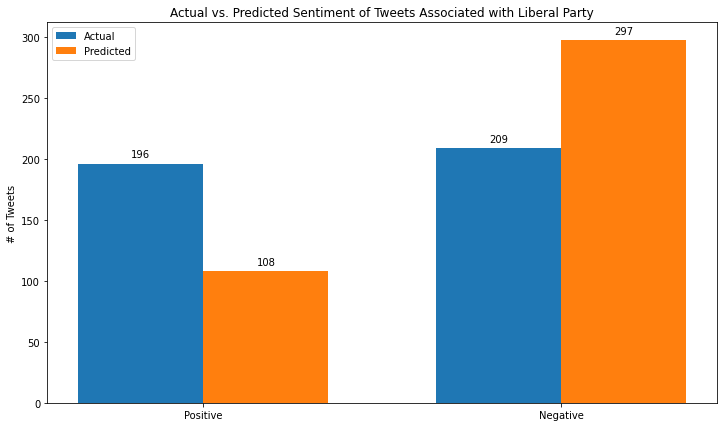

In [0]:
# For tweets associated with the Liberal party
labels = ['Positive', 'Negative']
x = np.arange(len(labels)) # Label locations
sent_count = SentimentCount(lib_df) # Number of tweets associated with actual positive and negative sentiment
pred_count = PredSentimentCount(lib_df) # Number of tweets associated with predicted positive and negative sentiment

fig, ax = plt.subplots(figsize=(12,7))
width = 0.35  # width of the bars
plt1 = ax.bar(x - width/2, sent_count, width, label='Actual') # actual sentiment of tweets
plt2 = ax.bar(x + width/2, pred_count, width, label='Predicted') # predicted sentiment of tweets
ax.set_ylabel('# of Tweets')
ax.set_title('Actual vs. Predicted Sentiment of Tweets Associated with Liberal Party')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

for i, v in enumerate(sent_count):
  plt.text(i - 0.2, v + 5, str(v), color='black') # add value labels to actual sentiment bars

for i, v in enumerate(pred_count):
  plt.text(i + 0.15, v + 5, str(v), color='black') # add value labels to predicted sentiment bars

plt.show()

The actual numbers of positive and negative sentiment tweets associated with the Liberal party are very close. Therefore, the public has a neutral with a slightly negative sentiment towards the Liberal party. However, a significant difference can be seen in the number of tweets of these two categories predicted by the model. The model underpredicted the number of positive sentiment tweets and overpredicted the number of negative sentiment tweets for those associated with the Liberal party. From the model, the public has a significantly more negative sentiment towards the Liberal party.

##### Conservative Party

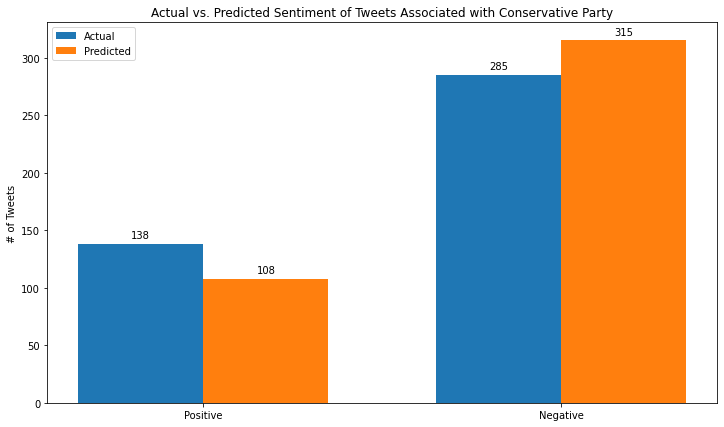

In [0]:
# For tweets associated with the Conservative party, code explained above
labels = ['Positive', 'Negative']
x = np.arange(len(labels))
sent_count = SentimentCount(cons_df)
pred_count = PredSentimentCount(cons_df)

fig, ax = plt.subplots(figsize=(12,7))
width = 0.35  # width of the bars
plt1 = ax.bar(x - width/2, sent_count, width, label='Actual') 
plt2 = ax.bar(x + width/2, pred_count, width, label='Predicted') 
ax.set_ylabel('# of Tweets')
ax.set_title('Actual vs. Predicted Sentiment of Tweets Associated with Conservative Party')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

for i, v in enumerate(sent_count):
  plt.text(i - 0.2, v + 5, str(v), color='black')

for i, v in enumerate(pred_count):
  plt.text(i + 0.15, v + 5, str(v), color='black')

plt.show()

There is a notable difference in the actual number of positive and negative sentiment tweets associated with the Conservative party. The public has a more negative sentiment towards the Conservative party. In comparison with the plot above for the Liberal party, the model was much better in predicting positive and negative sentiment for tweets associated with the Conservative party. A small difference is noted from the actual numbers as the model still underpredicted the number of positive sentiment tweets and overpredicted the number of negative sentiment tweets. From the model, the public has a slightly more negative sentiment towards the Conservative party than the actual numbers.

##### New Democratic Party

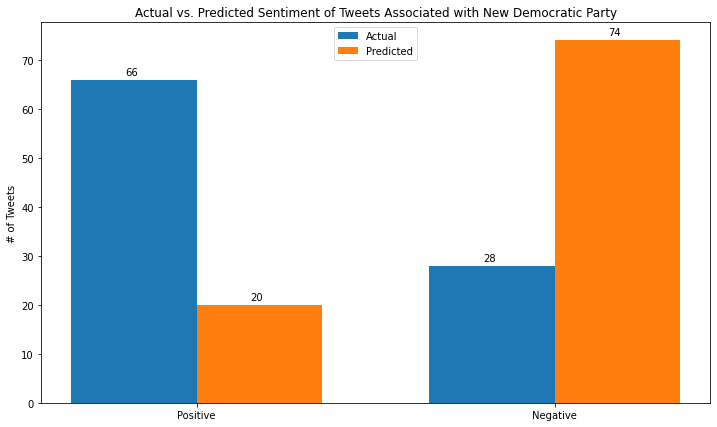

In [0]:
# For tweets associated with the NDP, code explained above
labels = ['Positive', 'Negative']
x = np.arange(len(labels))
sent_count = SentimentCount(ndp_df)
pred_count = PredSentimentCount(ndp_df)

fig, ax = plt.subplots(figsize=(12,7))
width = 0.35  # width of the bars
plt1 = ax.bar(x - width/2, sent_count, width, label='Actual')
plt2 = ax.bar(x + width/2, pred_count, width, label='Predicted')
ax.set_ylabel('# of Tweets')
ax.set_title('Actual vs. Predicted Sentiment of Tweets Associated with New Democratic Party')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc='upper center')

for i, v in enumerate(sent_count):
  plt.text(i - 0.2, v + 1, str(v), color='black')

for i, v in enumerate(pred_count):
  plt.text(i + 0.15, v + 1, str(v), color='black')

plt.show()

There is a notable difference in the actual number of positive and negative sentiment tweets associated with the NDP. The public has a more positive sentiment towards the NDP. The model predicted a similar difference, but the other way. Instead of having significantly more positive sentiment tweets than negative sentiment tweets, the model predicted significantly more negative sentiment tweets than positive sentiment tweets. It performed much worse in predicting positive and negative sentiment for tweets associated with the NDP. From the model, the public has a more negative sentiment rather than a more positive sentiment towards the NDP. 

#### Discussion of Results

<p><a href="https://en.wikipedia.org/wiki/2019_Canadian_federal_election#/media/File:Canada_Election_2019_Results_Map_(Simple).svg"><img src="https://upload.wikimedia.org/wikipedia/commons/b/b0/Canada_Election_2019_Results_Map_%28Simple%29.svg" alt="Canada Election 2019 Results Map (Simple).svg"></a><br>

From Wikipedia,
<a href="https://commons.wikimedia.org/wiki/File:Canada_Election_2019_Results_Map_(Simple).svg">Link</a></p>

The 2019 Canadian election outcomes:

*   Liberal party won the most seats (but not over 50%, minority government)
*   Conservative party won the most votes

*   NDP had less seats than Bloc Quebecois





**How well do your predictions match the sentiment labelled in the 2019 Canadian elections data?**

The tuned XGBoost model with WF as feature achieved the highest accuracy of 51.008% on the elections dataset. It has better precision for the 'Positive' sentiment than for the 'Negative' sentiment. 

**Discuss whether NLP analytics based on tweets is useful for political parties during election campaigns.**

NLP analytics based on tweets is definitely useful for political parties during election campagins. From the twitter sentiment analysis, wee see that the Liberal party was associated with the most positive sentiment tweets, with the Conservative party following second, and the NDP being last. This may be useful to explain the Liberal party's win of the most seats out of these parties. 

We can also gauge the parties that the public pays more attention to from the total number of tweets associated with each party. The Conservative party is associated with the highest number of tweets, followed by the Liberal party, and the NDP being last. This may be useful in estimating the potential number of votes that each party receives. For example, the NDP was associated with the least number of tweets and in reality, won the least votes out of these parties. Although the Conservative party has the highest potential number of votes, but the proportion of its positive sentiment tweets to negative sentiment tweets is much lower than that of the Liberal party, so it won less seats. 

Note that citizens who live in metropolitan areas are likely to use twitter more than those who live in rural areas. As a result, the twitter sentiment analysis may only be representative of the voting results in metropolitan areas. 

**Discuss ways to improve model accuracy.**

Despite being the top three parties that held the most seats in the previous election, Bloc Quebecois surpassed the NDP in its number of seats won in the 2019 election. However, as we did not include Bloc Quebecois in our analysis, we would not have been able to predict this outcome. The seats won by Bloc Quebecois are primarily located in the French-speaking province Quebec, so tweets in French may also need to be analyzed to predict the sentiment of those tweets. Furthermore, it is important to have more/better associated words that can associate the tweets to each political party. There are still many tweets in the 'Other' category that may be associated to one of the political parties which can lead to better prediction of election results.

With the given election tweets, the best model achieved an accuracy of 51.008% in predicting their sentiment. The current number of features used is 49 to avoid overly long run times. However, more features may be included to improve the accuracy of the model, but be cautious of the computing time. For the current features being used, the tweets are tokenized into individual words and may lose some of their meaning. As a result, other features such as N-gram may be a better option and should be tried to improve model accuracy. Furthermore, as the model was trained on the sentiment dataset, a more relevant sentiment dataset to the election tweets can be used to improve the accuracy of the model.

# Negative Reason of Election Tweets

To analyze the reasons of tweets associated with a negative sentiment, the positive sentiment tweets are dropped. 

In [0]:
# Drop all data points where sentiment is positive
elections_df = elections_df[elections_df['sentiment'] != 'Positive']

Looking at the negative reasons:

In [0]:
elections_df['negative_reason'].value_counts()

Others                                 364
Scandal                                270
Tell lies                              198
Economy                                 51
Women Reproductive right and Racism     45
Climate Problem                         41
Separation                              16
Privilege                               12
Healthcare                               5
Healthcare and Marijuana                 4
Name: negative_reason, dtype: int64

We see there are similarities between some of the negative reasons. As a result, they are grouped together, and the resulting negative reasons are:

*   Others
*   Scandal

*   Tell lies
*   Society (Women Reproductive right and Racism, Separation, Privilege)

*   Economy
*   Climate Problem

*   Healthcare (Healthcare, Healthcare and Marijuana)









In [0]:
elections_df['negative_reason'] = elections_df['negative_reason'].replace('Women Reproductive right and Racism', 'Society')
elections_df['negative_reason'] = elections_df['negative_reason'].replace('Separation', 'Society')
elections_df['negative_reason'] = elections_df['negative_reason'].replace('Privilege', 'Society')

elections_df['negative_reason'] = elections_df['negative_reason'].replace('Healthcare and Marijuana', 'Healthcare')

In [0]:
elections_df['negative_reason'].value_counts()

Others             364
Scandal            270
Tell lies          198
Society             73
Economy             51
Climate Problem     41
Healthcare           9
Name: negative_reason, dtype: int64

The negative reasons are of categorical data and are converted to numerical data before model implementation. 

In [0]:
elections_df['encoded_negreason'] = elections_df['negative_reason'].map({
    'Others': 0, 
    'Scandal': 1,
    'Tell lies': 2,
    'Society': 3,
    'Economy': 4,
    'Climate Problem': 5,
    'Healthcare': 6})

In [0]:
elections_df.head()

,sentiment,negative_reason,text,cleaned_text,word_count,party,encoded_sentiment,join_text,predicted_sentiment,encoded_negreason
0,Negative,Society,"b""@RosieBarton So instead of your suggestion, ...","[rosiebarton, suggestion, agree, canadian, wom...",18,Conservative,0,rosiebarton suggestion agree canadian women tr...,1,3
2,Negative,Economy,"b""#Brantford It's going to cost YOU $94 BILLIO...","[brantford, going, cost, 94, billion, 4, years...",11,Liberal,0,brantford going cost 94 billion 4 years justin...,0,4
4,Negative,Economy,"b""#Canada #taxpayers are sick &amp; tired of h...","[canada, taxpayers, sick, amp, tired, hard, ea...",23,Other,0,canada taxpayers sick amp tired hard earned do...,0,4
5,Negative,Others,"b""#CanadaVotes2019 #elxn43 #cdnpoli - FACTS - ...","[canadavotes2019, elxn43, cdnpoli, facts, blas...",21,Conservative,0,canadavotes2019 elxn43 cdnpoli facts blastfrom...,0,0
8,Negative,Others,"b""#chooseforward #cdnpoli #elxn43\nCanada, Don...","[chooseforward, cdnpoli, elxn43ncanada, dont, ...",10,Other,0,chooseforward cdnpoli elxn43ncanada dont ameri...,0,0


In [0]:
elections_df['encoded_negreason'].value_counts()

0    364
1    270
2    198
3     73
4     51
5     41
6      9
Name: encoded_negreason, dtype: int64

It was noted from above that the negative reasons are quite imbalanced, with reasons such as 'Others', 'Scandal' and 'Tell lies' being in the hundreds, while 'Healthcare' is less than 10. As a result, stratification is used when splitting the dataset into training and testing data to account for the different proportions.   

In [0]:
# Splitting elections dataframe into training and testing data
X_train, X_test, y_train, y_test = train_test_split(elections_df['join_text'], elections_df['encoded_negreason'], 
                              test_size=0.3, random_state=0, stratify=elections_df['encoded_negreason'])

Two features, WF and TF-IDF, are used and compared with the following models for multi-class classification of negative reason:

*   Logistic Regression
*   Decision Trees

*   Random Forest

## Feature: WF

In [0]:
WF_vect = CountVectorizer(min_df=0.02) # Call CountVectorizer and ignore terms that have a frequency lower than 0.02
WF_train = WF_vect.fit_transform(X_train).toarray() # Fit vectorizer using training data and transform training data
WF_test = WF_vect.transform(X_test).toarray() # Transform testing data using fitted vectorizer

WFtrain_df = pd.DataFrame(WF_train, columns=WF_vect.get_feature_names()) # Obtain training data results in dataframe
WFtest_df = pd.DataFrame(WF_test, columns=WF_vect.get_feature_names()) # Obtain testing data results in dataframe

In [0]:
WFtrain_df.head()

,amp,andrew,andrewscheer,answer,bernier,campaign,canada,canadian,canadians,cbckatie,cdnelxn2019,cdnpoli,chooseforward,climate,conservative,conservatives,country,cpc,cpc_hq,day,destroy,dirty,dont,donxe2x80x99t,election,elxn2019,elxn43,firm,going,good,hired,justin,justintrudeau,kinsella,kinsellagate,kinsellawarren,leader,liberal,liberal_party,liberals,lie,lies,maximebernier,media,monday,ncdnpoli,ndp,nelxn43,news,nnelxn43,paid,party,pay,people,policy,political,ppc,ppc2019,question,questions,scheer,smear,support,time,trudeau,trudeaumustgo,vote,voters,warren,will,years
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,1


In [0]:
WFtrain_df.shape

(704, 71)

In [0]:
WFtest_df.head()

,amp,andrew,andrewscheer,answer,bernier,campaign,canada,canadian,canadians,cbckatie,cdnelxn2019,cdnpoli,chooseforward,climate,conservative,conservatives,country,cpc,cpc_hq,day,destroy,dirty,dont,donxe2x80x99t,election,elxn2019,elxn43,firm,going,good,hired,justin,justintrudeau,kinsella,kinsellagate,kinsellawarren,leader,liberal,liberal_party,liberals,lie,lies,maximebernier,media,monday,ncdnpoli,ndp,nelxn43,news,nnelxn43,paid,party,pay,people,policy,political,ppc,ppc2019,question,questions,scheer,smear,support,time,trudeau,trudeaumustgo,vote,voters,warren,will,years
0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
WFtest_df.shape

(302, 71)

### Model Training

The algorithms with their default parameters are used on the training data.

#### Logistic Regression

In [0]:
# Logistic Regression
print("Logistic Regression:")
model = LogisticRegression(max_iter=1000)
accuracy7 = K_Fold1(WFtrain_df, y_train, model)
print("Cross-validation score of {}% with a variance of {}%" .format(round(np.mean(accuracy7), 3), round(np.var(accuracy7), 3)))

Logistic Regression:
Fold 1: Accuracy = 58.537%
Fold 2: Accuracy = 75.0%
Fold 3: Accuracy = 75.556%
Fold 4: Accuracy = 69.444%
Fold 5: Accuracy = 64.286%
Fold 6: Accuracy = 78.378%
Fold 7: Accuracy = 58.974%
Fold 8: Accuracy = 72.727%
Fold 9: Accuracy = 65.854%
Fold 10: Accuracy = 61.905%
Cross-validation score of 68.066% with a variance of 46.476%


#### Decision Trees

In [0]:
# Decision Trees
print("Decision Trees:")
model = DecisionTreeClassifier()
accuracy7 = K_Fold1(WFtrain_df, y_train, model)
print("Cross-validation score of {}% with a variance of {}%" .format(round(np.mean(accuracy7), 3), round(np.var(accuracy7), 3)))

Decision Trees:
Fold 1: Accuracy = 58.333%
Fold 2: Accuracy = 51.613%
Fold 3: Accuracy = 71.795%
Fold 4: Accuracy = 67.742%
Fold 5: Accuracy = 63.158%
Fold 6: Accuracy = 71.429%
Fold 7: Accuracy = 71.875%
Fold 8: Accuracy = 56.757%
Fold 9: Accuracy = 60.606%
Fold 10: Accuracy = 48.571%
Cross-validation score of 62.188% with a variance of 64.741%


#### Random Forest

In [0]:
# Random Forest
print("Random Forest:")
model = RandomForestClassifier()
accuracy7 = K_Fold1(WFtrain_df, y_train, model)
print("Cross-validation score of {}% with a variance of {}%" .format(round(np.mean(accuracy7), 3), round(np.var(accuracy7), 3)))

Random Forest:
Fold 1: Accuracy = 68.421%
Fold 2: Accuracy = 68.571%
Fold 3: Accuracy = 73.171%
Fold 4: Accuracy = 75.758%
Fold 5: Accuracy = 71.795%
Fold 6: Accuracy = 64.516%
Fold 7: Accuracy = 73.684%
Fold 8: Accuracy = 61.905%
Fold 9: Accuracy = 61.538%
Fold 10: Accuracy = 65.909%
Cross-validation score of 68.527% with a variance of 22.677%


The accuracies obtained from the three models ranged from the low 60s to the high 60s with significantly higher variances than previously observed for sentiment training data.

### Model Tuning

Grid search is used to perform hyperparameter tuning for each of the models on elections training data with 10-fold cross-validation. The varied hyperparameters are the same as those in the previous model tuning section.

The following codes have been commented out to avoid overly long runtimes. The best parameters of each model which resulted in the highest accuracy are recorded.

#### Logistic Regression

In [0]:
#GridSearchLogModel(WFtrain_df, y_train)

The optimal log model uses C=10 and solver=lbfgs, and has a cross validation score of 69.935% with a variance of 48.706%


Logistic Regression:

The optimal model uses C=10 and solver=lbfgs, and has a cross validation score of 69.935% with a variance of 48.706%

#### Decision Trees

In [0]:
#GridSearchDTModel(WFtrain_df, y_train)

The optimal DT model uses criterion=gini, max_depth=10, and min_samples_leaf=10, and has a cross validation score of 68.229% with a variance of 22.549%


Decision Trees:

The optimal model uses criterion=gini, max_depth=10, and min_samples_leaf=10, and has a cross validation score of 68.229% with a variance of 22.549%

#### Random Forest

In [0]:
#GridSearchRFModel(WFtrain_df, y_train)

The optimal RF model uses n_estimators=500, max_depth=100, and min_samples_leaf=2, and has a cross validation score of 69.521% with a variance of 30.71%


Random Forest:

The optimal model uses n_estimators=500, max_depth=100, and min_samples_leaf=2, and has a cross validation score of 69.521% with a variance of 30.71%

After hyperparameter tuning, all the models achieved higher accuracies with similar variances as compared with the default parameters. 

### Model Testing

The hyperparameters for each model that resulted in the highest accuracy are used on the elections testing data.

In [0]:
# Logistic Regression with tuned hyperparameters
print("Logistic Regression:")
model = LogisticRegression(C=10, solver='lbfgs', max_iter=1000)
model.fit(WFtrain_df, y_train)
y_pred1 = model.predict(WFtest_df)
accuracy = accuracy_score(y_test, y_pred1) * 100
print("Accuracy = {}%" .format(round(accuracy, 3)))

Logistic Regression:
Accuracy = 46.026%


In [0]:
# Decision Tree with tuned hyperparameters
print("Decision Trees:")
model = DecisionTreeClassifier(criterion='gini', max_depth=10, min_samples_leaf=10)
model.fit(WFtrain_df, y_train)
y_pred2 = model.predict(WFtest_df)
accuracy = accuracy_score(y_test, y_pred2) * 100
print("Accuracy = {}%" .format(round(accuracy, 3)))

Decision Trees:
Accuracy = 50.993%


In [0]:
# Random Forest with tuned hyperparameters
print("Random Forest:")
model = RandomForestClassifier(n_estimators=500, max_depth=100, min_samples_leaf=2)
model.fit(WFtrain_df, y_train)
y_pred3 = model.predict(WFtest_df)
accuracy = accuracy_score(y_test, y_pred3) * 100
print("Accuracy = {}%" .format(round(accuracy, 3)))

Random Forest:
Accuracy = 49.669%


With WF as feature, the tuned decision tree model achieved the highest accuracy of 50.993%. 

In [0]:
print(classification_report(y_test, y_pred2))

              precision    recall  f1-score   support

           0       0.44      0.89      0.59       109
           1       0.63      0.44      0.52        81
           2       0.82      0.23      0.36        60
           3       0.00      0.00      0.00        22
           4       0.40      0.13      0.20        15
           5       1.00      0.42      0.59        12
           6       0.00      0.00      0.00         3

    accuracy                           0.51       302
   macro avg       0.47      0.30      0.32       302
weighted avg       0.55      0.51      0.46       302



## Feature: TFIDF

In [0]:
TFIDF_vect = TfidfVectorizer(max_features=71) # Call TfidfVectorizer and choose an equivalent number of features as WF
TFIDF_train = TFIDF_vect.fit_transform(X_train).toarray()
TFIDF_test = TFIDF_vect.transform(X_test).toarray()

TFIDFtrain_df = pd.DataFrame(TFIDF_train, columns=TFIDF_vect.get_feature_names())
TFIDFtest_df = pd.DataFrame(TFIDF_test, columns=TFIDF_vect.get_feature_names())

In [0]:
TFIDFtrain_df.head()

,amp,andrew,andrewscheer,answer,bernier,campaign,canada,canadian,canadians,cbckatie,cdnelxn2019,cdnpoli,chooseforward,climate,conservative,conservatives,country,cpc,cpc_hq,ctvnews,destroy,dirty,dont,donxe2x80x99t,election,elxn2019,elxn43,firm,going,good,hired,justin,justintrudeau,kinsella,kinsellagate,kinsellawarren,leader,liberal,liberal_party,liberals,lie,lies,maximebernier,media,ncdnpoli,ndp,nelxn43,news,nnelxn43,paid,party,pay,people,policy,political,ppc,ppc2019,question,questions,rights,scheer,smear,support,time,trudeau,trudeaumustgo,vote,voters,warren,will,years
0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.174944,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.666795,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.549988,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.471478,0.0,0.0,0.0,0.0,0.0,0.000000
1,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
2,0.0,0.0,0.0,0.0,0.0,0.59084,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.605761,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.196567,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.495301,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
3,0.0,0.0,0.0,0.0,0.0,0.00000,0.385776,0.0,0.0,0.0,0.0,0.203851,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.45797,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.454527,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.499901,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.378668,0.0,0.0,0.0,0.0,0.0,0.000000
4,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.213175,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.146933,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.791976,0.0,0.0,0.0,0.0,0.0,0.552938


In [0]:
TFIDFtrain_df.shape

(704, 71)

In [0]:
TFIDFtest_df.head()

,amp,andrew,andrewscheer,answer,bernier,campaign,canada,canadian,canadians,cbckatie,cdnelxn2019,cdnpoli,chooseforward,climate,conservative,conservatives,country,cpc,cpc_hq,ctvnews,destroy,dirty,dont,donxe2x80x99t,election,elxn2019,elxn43,firm,going,good,hired,justin,justintrudeau,kinsella,kinsellagate,kinsellawarren,leader,liberal,liberal_party,liberals,lie,lies,maximebernier,media,ncdnpoli,ndp,nelxn43,news,nnelxn43,paid,party,pay,people,policy,political,ppc,ppc2019,question,questions,rights,scheer,smear,support,time,trudeau,trudeaumustgo,vote,voters,warren,will,years
0,0.0,0.000000,0.0,0.0,0.369559,0.0,0.0,0.0,0.0,0.0,0.0,0.144221,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.378884,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.32157,0.0,0.0,0.279701,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.346782,0.0,0.281127,0.0,0.000000,0.0,0.357354,0.0,0.0,0.0,0.0,0.0,0.250479,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.357354,0.0,0.0
1,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.174783,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.549481,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.522233,0.628326,0.000000,0.0,0.0
2,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.961985,0.0,0.0,0.273102,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0
3,0.0,0.584796,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.504829,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.179417,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.609074,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0
4,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0


In [0]:
TFIDFtest_df.shape

(302, 71)

### Model Training

The algorithms with their default parameters are used on the training data.

#### Logistic Regression

In [0]:
# Logistic Regression
print("Logistic Regression:")
model = LogisticRegression(max_iter=1000)
accuracy = K_Fold1(TFIDFtrain_df, y_train, model)
print("Cross-validation score of {}% with a variance of {}%" .format(round(np.mean(accuracy7), 3), round(np.var(accuracy7), 3)))

Logistic Regression:
Fold 1: Accuracy = 59.524%
Fold 2: Accuracy = 77.5%
Fold 3: Accuracy = 73.333%
Fold 4: Accuracy = 71.795%
Fold 5: Accuracy = 65.116%
Fold 6: Accuracy = 68.571%
Fold 7: Accuracy = 63.889%
Fold 8: Accuracy = 69.767%
Fold 9: Accuracy = 65.854%
Fold 10: Accuracy = 63.043%
Cross-validation score of 67.839% with a variance of 26.252%


#### Decision Trees

In [0]:
# Decision Trees
print("Decision Trees:")
model = DecisionTreeClassifier()
accuracy = K_Fold1(TFIDFtrain_df, y_train, model)
print("Cross-validation score of {}% with a variance of {}%" .format(round(np.mean(accuracy7), 3), round(np.var(accuracy7), 3)))

Decision Trees:
Fold 1: Accuracy = 70.27%
Fold 2: Accuracy = 66.667%
Fold 3: Accuracy = 60.526%
Fold 4: Accuracy = 68.966%
Fold 5: Accuracy = 64.865%
Fold 6: Accuracy = 68.966%
Fold 7: Accuracy = 75.676%
Fold 8: Accuracy = 52.5%
Fold 9: Accuracy = 54.545%
Fold 10: Accuracy = 59.375%
Cross-validation score of 64.236% with a variance of 48.735%


#### Random Forest

In [0]:
# Random Forest
print("Random Forest:")
model = RandomForestClassifier()
accuracy = K_Fold1(TFIDFtrain_df, y_train, model)
print("Cross-validation score of {}% with a variance of {}%" .format(round(np.mean(accuracy7), 3), round(np.var(accuracy7), 3)))

Random Forest:
Fold 1: Accuracy = 63.415%
Fold 2: Accuracy = 73.171%
Fold 3: Accuracy = 69.767%
Fold 4: Accuracy = 64.706%
Fold 5: Accuracy = 57.143%
Fold 6: Accuracy = 58.824%
Fold 7: Accuracy = 75.0%
Fold 8: Accuracy = 61.364%
Fold 9: Accuracy = 73.81%
Fold 10: Accuracy = 64.103%
Cross-validation score of 66.13% with a variance of 37.084%


The accuracies obtained from the three models ranged from the low 60s to the high 60s with significantly higher variances than previously observed for sentiment training data.

### Model Tuning

Grid search is used to perform hyperparameter tuning for each of the models on elections training data with 10-fold cross-validation. The varied hyperparameters are the same as those in the previous model tuning section.

The following codes have been commented out to avoid overly long runtimes. The best parameters of each model which resulted in the highest accuracy are recorded.

#### Logistic Regression

In [0]:
#GridSearchLogModel(TFIDFtrain_df, y_train)

The optimal log model uses C=10 and solver=newton-cg, and has a cross validation score of 70.927% with a variance of 47.361%


Logistic Regression:

The optimal model uses C=10 and solver=newton-cg, and has a cross validation score of 70.927% with a variance of 47.361%

#### Decision Trees

In [0]:
#GridSearchDTModel(TFIDFtrain_df, y_train)

The optimal DT model uses criterion=gini, max_depth=10, and min_samples_leaf=10, and has a cross validation score of 66.645% with a variance of 36.855%


Decision Trees:

The optimal model uses criterion=gini, max_depth=10, and min_samples_leaf=10, and has a cross validation score of 66.645% with a variance of 36.855%

#### Random Forest

In [0]:
#GridSearchRFModel(TFIDFtrain_df, y_train)

The optimal RF model uses n_estimators=250, max_depth=50, and min_samples_leaf=5, and has a cross validation score of 68.754% with a variance of 24.776%


Random Forest:

The optimal model uses n_estimators=250, max_depth=50, and min_samples_leaf=5, and has a cross validation score of 68.754% with a variance of 24.776%

After hyperparameter tuning, all the models achieved higher accuracies with similar variances as compared with the default parameters. 

### Model Testing

The hyperparameters for each model that resulted in the highest accuracy are used on the elections testing data.

In [0]:
# Logistic Regression with tuned hyperparameters
print("Logistic Regression:")
model = LogisticRegression(C=10, solver='newton-cg', max_iter=1000)
model.fit(TFIDFtrain_df, y_train)
y_pred1 = model.predict(TFIDFtest_df)
accuracy = accuracy_score(y_test, y_pred1) * 100
print("Accuracy = {}%" .format(round(accuracy, 3)))

Logistic Regression:
Accuracy = 48.013%


In [0]:
# Decision Tree with tuned hyperparameters
print("Decision Trees:")
model = DecisionTreeClassifier(criterion='gini', max_depth=10, min_samples_leaf=10)
model.fit(TFIDFtrain_df, y_train)
y_pred2 = model.predict(TFIDFtest_df)
accuracy = accuracy_score(y_test, y_pred2) * 100
print("Accuracy = {}%" .format(round(accuracy, 3)))

Decision Trees:
Accuracy = 51.987%


In [0]:
# Random Forest with tuned hyperparameters
print("Random Forest:")
model = RandomForestClassifier(n_estimators=250, max_depth=50, min_samples_leaf=5)
model.fit(TFIDFtrain_df, y_train)
y_pred3 = model.predict(TFIDFtest_df)
accuracy = accuracy_score(y_test, y_pred3) * 100
print("Accuracy = {}%" .format(round(accuracy, 3)))

Random Forest:
Accuracy = 51.325%


With TF-IDF as feature, the tuned decision trees model achieved the highest accuracy of 51.987%. This model also achieved the highest accuracy overall in comparison with models using WF as feature.

In [0]:
print(classification_report(y_test, y_pred2))

              precision    recall  f1-score   support

           0       0.46      0.90      0.60       109
           1       0.64      0.44      0.53        81
           2       0.78      0.23      0.36        60
           3       0.75      0.14      0.23        22
           4       0.25      0.07      0.11        15
           5       1.00      0.42      0.59        12
           6       0.00      0.00      0.00         3

    accuracy                           0.52       302
   macro avg       0.55      0.31      0.34       302
weighted avg       0.60      0.52      0.48       302



## Visualization of Results

Using the model that obtained the highest overall accuracy:

In [0]:
# Obtain only the testing data
index = X_test.index
test_df = elections_df.loc[index,:]
test_df['predicted_negreason'] = y_pred2

In [0]:
test_df.head()

,sentiment,negative_reason,text,cleaned_text,word_count,party,encoded_sentiment,join_text,predicted_sentiment,encoded_negreason,predicted_negreason
1161,Negative,Scandal,"b'Allegedly, Scheer hired Warren Kinsella - a ...","[ballegedly, scheer, hired, warren, kinsella, ...",24,Conservative,0,ballegedly scheer hired warren kinsella toront...,0,1,1
361,Negative,Others,"b""Just a reminder that whatever happens on Mon...","[reminder, monday, shit, voter, turnout, 30, v...",17,Other,0,reminder monday shit voter turnout 30 vote 15 ...,0,0,1
854,Negative,Society,b'@JustinTrudeau @melaniejoly Pls don\xe2\x80\...,"[bjustintrudeau, melaniejoly, pls, donxe2x80x9...",9,Other,0,bjustintrudeau melaniejoly pls donxe2x80x99t t...,0,3,0
337,Negative,Scandal,"b""I'd hate to be a CPC candidate in a toss-up ...","[hate, cpc, candidate, tossup, riding, lraitt,...",18,Conservative,0,hate cpc candidate tossup riding lraitt speak ...,0,1,1
473,Negative,Scandal,"b""The thing is, why are the media officially e...","[thing, media, officially, endorsing, candidat...",10,Other,0,thing media officially endorsing candidates th...,0,1,1


In [0]:
# Obtain the number of tweets associated with each of the negative reason categories
def NegreasonCount(df):
  
  count = []
  zero_count = sum(df['encoded_negreason'] == 0) # Number of tweets associated with 'Others'
  count.append(zero_count) # Append to list
  one_count = sum(df['encoded_negreason'] == 1) # Number of tweets associated with 'Scandal'
  count.append(one_count) # Append to list
  two_count = sum(df['encoded_negreason'] == 2) # Number of tweets associated with 'Tell lies'
  count.append(two_count) # Append to list
  three_count = sum(df['encoded_negreason'] == 3) # Number of tweets associated with 'Society'
  count.append(three_count) # Append to list
  four_count = sum(df['encoded_negreason'] == 4) # Number of tweets associated with 'Economy'
  count.append(four_count) # Append to list
  five_count = sum(df['encoded_negreason'] == 5) # Number of tweets associated with 'Climate Problem'
  count.append(five_count) # Append to list
  six_count = sum(df['encoded_negreason'] == 6) # Number of tweets associated with 'Healthcare'
  count.append(six_count) # Append to list

  return count

In [0]:
# Obtain the number of tweets associated with each of the predicted negative reason categories
def PredNegreasonCount(df):
  
  count = []
  zero_count = sum(df['predicted_negreason'] == 0) # Number of tweets associated with 'Others'
  count.append(zero_count) # Append to list
  one_count = sum(df['predicted_negreason'] == 1) # Number of tweets associated with 'Scandal'
  count.append(one_count) # Append to list
  two_count = sum(df['predicted_negreason'] == 2) # Number of tweets associated with 'Tell lies'
  count.append(two_count) # Append to list
  three_count = sum(df['predicted_negreason'] == 3) # Number of tweets associated with 'Society'
  count.append(three_count) # Append to list
  four_count = sum(df['predicted_negreason'] == 4) # Number of tweets associated with 'Economy'
  count.append(four_count) # Append to list
  five_count = sum(df['predicted_negreason'] == 5) # Number of tweets associated with 'Climate Problem'
  count.append(five_count) # Append to list
  six_count = sum(df['predicted_negreason'] == 6) # Number of tweets associated with 'Healthcare'
  count.append(six_count) # Append to list

  return count

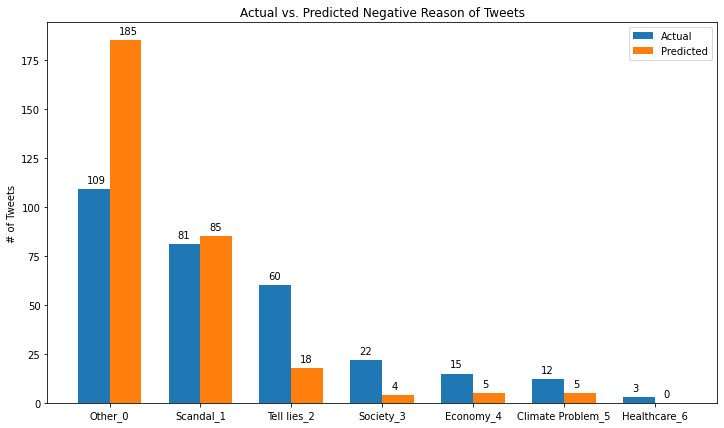

In [0]:
labels = ['Other_0', 'Scandal_1', 'Tell lies_2', 'Society_3', 'Economy_4', 'Climate Problem_5', 'Healthcare_6']
x = np.arange(len(labels)) # label locations
negreason_count = NegreasonCount(test_df) # number of tweets associated with each of the actual negative reason categories
pred_negreason_count = PredNegreasonCount(test_df) # number of tweets associated with each of the predicted negative reason categories

fig, ax = plt.subplots(figsize=(12,7))
width = 0.35  # width of the bars
plt1 = ax.bar(x - width/2, negreason_count, width, label='Actual') # actual negative reason of tweets
plt2 = ax.bar(x + width/2, pred_negreason_count, width, label='Predicted') # predicted negative reason of tweets
ax.set_ylabel('# of Tweets')
ax.set_title('Actual vs. Predicted Negative Reason of Tweets')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

for i, v in enumerate(negreason_count):
  plt.text(i - 0.25, v + 3, str(v), color='black') # add value labels to actual negative reason bars

for i, v in enumerate(pred_negreason_count):
  plt.text(i + 0.1, v + 3, str(v), color='black') # add value labels to predicted negative reason bars

plt.show()

The predicted negative reasons have a similar distribution to the actual negative reasons, with the highest number of tweets determined to be associated with 'Other' and decreasing each time for the remaining reasons. However, the model significantly overpredicted 'Other' and underpredicted the remaining reasons. 

## Discussion of Results

**How well do your predictions match the negative reason labelled in the 2019 Canadian elections data?**

The tuned decision tree model with TF-IDF as feature achieved the highest accuracy of 51.987% on the testing data. It has the highest precision for 'Climate Problem' (5), followed by 'Tell lies' (2), 'Society' (3), 'Scandal' (1), 'Others' (0), 'Economy' (4), and lastly 'Healthcare' (6). 

**Discuss reasons why your model failed to predict the correct negative reason.**



In [0]:
y_test.value_counts()

0    109
1     81
2     60
3     22
4     15
5     12
6      3
Name: encoded_negreason, dtype: int64

As seen in the plot above and from the value_counts of the testing data, the issue of having imbalanced negative reasons persists although it was attempted to be solved by using stratification when splitting the dataset into training and testing data. The 'Others' reason dominates as it is associated with around 33% of the tweets, while the 'Healthcare' reason is only associated with 1% of the tweets. There are just not enough tweets for the model to train on to better distinguish negative reasons such as 'Society', 'Economy', 'Climate Problem', and especially 'Healthcare'. The model did not predict any tweets as belonging to the 'Healthcare' reason. 

In [0]:
TFIDFtest_df.head()

,amp,andrew,andrewscheer,answer,bernier,campaign,canada,canadian,canadians,cbckatie,cdnelxn2019,cdnpoli,chooseforward,climate,conservative,conservatives,country,cpc,cpc_hq,ctvnews,destroy,dirty,dont,donxe2x80x99t,election,elxn2019,elxn43,firm,going,good,hired,justin,justintrudeau,kinsella,kinsellagate,kinsellawarren,leader,liberal,liberal_party,liberals,lie,lies,maximebernier,media,ncdnpoli,ndp,nelxn43,news,nnelxn43,paid,party,pay,people,policy,political,ppc,ppc2019,question,questions,rights,scheer,smear,support,time,trudeau,trudeaumustgo,vote,voters,warren,will,years
0,0.0,0.000000,0.0,0.0,0.369559,0.0,0.0,0.0,0.0,0.0,0.0,0.144221,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.378884,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.32157,0.0,0.0,0.279701,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.346782,0.0,0.281127,0.0,0.000000,0.0,0.357354,0.0,0.0,0.0,0.0,0.0,0.250479,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.357354,0.0,0.0
1,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.174783,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.549481,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.522233,0.628326,0.000000,0.0,0.0
2,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.961985,0.0,0.0,0.273102,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0
3,0.0,0.584796,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.504829,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.179417,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.609074,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0
4,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0


Furthermore, the imbalance in negative reasons affects the words selected as features. As there are more tweets associated with the 'Others' negative reason, the word features determined may be biased towards this negative reason. Taking a look at the features used in the best model above, none seem to be directly associated with 'Economy', increasing the difficulty for the model to predict this reason, resulting in its low precision.

**Discuss ways to improve model accuracy.**

With the given election tweets, the best model achieved an accuracy of 51.987% in predicting their negative reason. More features may be included to improve the representation of words associated with each of the negative reasons. As a result, the model accuracy will be improved. However, we need to be cautious of the computing time required. For the current features being used, the tweets are tokenized into individual words and may lose some of their meaning. As a result, other features, such as N-gram, may be a better option and should be tried to improve model accuracy. Furthermore, we can use other datasets to determine word features better related to these negative reasons. As a result, the selected word features would be more targeted but may introduce more bias.

To mitigate the issue of having imbalanced negative reasons, they can be further grouped to eliminate ones with very few associated tweets. If possible, more tweets associated with the negative reasons that are less represented can also be added for a more balanced representation to improve model accuracy. 